## Siemens FDA

**Index**

1. Loading the datasets
2. Transposing the time series datasets
3. Merging time series datasets to add additional features
4. Filtering and spliting in Blood and aqueous groups
5. Window extraction
   - 5.1. Validating if there are partial or full missing values after the extraction
   - 5.2 Visualize the origin window intervals in different groups of Features
6. Additional Functions
   7.1. Visualization of plots with raw data after the extraction.
   7.2. Visualization of plots with data centered after the extraction.
7. Visualization of Time Series from the Windows
8. Functional PCA (Visualization of Principal Component Plots in one row)
    - 8.1. Functional PCA characterization function
    - 8.2 Functional PC1 plots (both systems)  Characterization of FPC Scores
    - 8.3 Linear Reregression
9. Fuctional regression
     

The improvements with respect to the code "Siemens_FDA.ipynb" are:
- Change the part in "Filtering and spliting in Bloods and Aqueous groups" for sample the data
- Change the "Merge data" Function in "Additional functions"
- Add 8.3 "Linear Regression" to make statistic summary for PCA(still developing)
- Update 7.2 function "plot_all_time_series_in_group" with a new function to save the photos

# 1. Loading the datasets

In [1]:
#!pip install scikit-fda

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import random
from sklearn.decomposition import PCA
from skfda.representation.grid import FDataGrid
from skfda.preprocessing.dim_reduction.projection import FPCA
from sklearn.preprocessing import OneHotEncoder
import skfda
from skfda.ml.regression import LinearRegression
from skfda.representation.basis import FDataBasis, FourierBasis

/var/folders/_c/wdm33bq11dvflh73ffxrd8z40000gn/T/ipykernel_25777/2677705551.py:9: DeprecationWarning: The module "projection" is deprecated. Please use "dim_reduction"
  from skfda.preprocessing.dim_reduction.projection import FPCA


# 2. Transposing the time series datasets

You can change this part based on where you store the data

In [3]:
# Import datasets
sensorA_System1 = pd.read_csv("RawData/System1_SensorA.csv")
sensorA_System2 = pd.read_csv("RawData/System2_SensorA.csv")
sensorB_System1 = pd.read_csv("RawData/System1_SensorB.csv")
sensorB_System2 = pd.read_csv("RawData/System2_SensorB.csv")
sensorA_System1_missing = pd.read_csv("RawData/SensorA_System1_missing values.csv")
sensorA_System2_missing = pd.read_csv("RawData/SensorA_System2_missing values.csv")
keyByTestID = pd.read_csv("RawData/Key by TestID.csv", parse_dates=['DateTime'])

# 3. Merging time series datasets to add additional features

In [4]:
# Transpose dataset to make columns as timestamps and rows as tests

# Sensor A
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

A1_missing_transposed = sensorA_System1_missing.T.reset_index()
A1_missing_transposed.columns = A1_missing_transposed.iloc[0]
A1_missing_transposed.rename(columns={A1_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A1_missing_transposed = A1_missing_transposed.drop(0)
A1_missing_transposed['TestID'] = A1_missing_transposed['TestID'].astype(int)

A2_missing_transposed = sensorA_System2_missing.T.reset_index()
A2_missing_transposed.columns = A2_missing_transposed.iloc[0]
A2_missing_transposed.rename(columns={A2_missing_transposed.columns[0]: 'TestID'}, inplace=True)
A2_missing_transposed = A2_missing_transposed.drop(0)
A2_missing_transposed['TestID'] = A2_missing_transposed['TestID'].astype(int)

# Sensor B
B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

In [5]:
# Complete A1 and A2 with the missing values
A1_transposed_mid = A1_transposed[~A1_transposed.TestID.isin(A1_missing_transposed.TestID)]
A1_transposed = pd.concat([A1_transposed_mid, A1_missing_transposed], axis=0)
A2_transposed_mid = A2_transposed[~A2_transposed.TestID.isin(A2_missing_transposed.TestID)]
A2_transposed = pd.concat([A2_transposed_mid, A2_missing_transposed], axis=0)

In [6]:
# Create new column to fill fluid temperature NA's
# Note: Fluid temperature: If specified, take as the temperature of the sample fluid. The rest of the system temperature can be taken as ambient temperature.

keyByTestID['Fluid_Temperature_Filled'] = keyByTestID['Fluid Temperature'].combine_first(keyByTestID['AmbientTemperature'])
keyByTestID.head(3)

TestID    FluidType            DateTime          Lot  CardNumber  \
0  3550995  Eurotrol L1 2024-02-07 10:32:15  16-23333-20      302910   
1  3550995  Eurotrol L1 2024-02-07 10:32:15  16-23333-20      302910   
2  3551012  Eurotrol L1 2024-02-07 10:41:33  16-23333-20      303096   

   AgeOfCardInDaysAtTimeOfTest  ReaderSerialNumber  SampleDetectTime  \
0                           70                  73             180.4   
1                           70                  73             180.4   
2                           70                  73             183.2   

   BubbleDetectTime     System    Sensor  AmbientTemperature  \
0             178.8  System 2A  Sensor A             21.2345   
1             178.8  System 2A  Sensor B             21.2345   
2             181.6  System 2A  Sensor A             21.5012   

   Fluid Temperature CardReturnCode ReturnCode Results Error Code  \
0                NaN            NaN    Success            NoError   
1                NaN            NaN    Success            NoError   
2                NaN            NaN    Success            NoError   

  Device Return Code Bge Test ReturnCode  Fluid_Temperature_Filled  
0            NoError             Success                   21.2345  
1            NoError             Success                   21.2345  
2            NoError             Success                   21.5012

In [7]:
# Relabeling System Values
keyByTestID["System"] = keyByTestID["System"].replace({"System 2A":"System 2","System 2B":"System 2"})
keyByTestID.tail(3)

TestID FluidType            DateTime          Lot  CardNumber  \
24255  3518677       HNB 2023-09-19 16:54:21  16-23151-20      302186   
24256  3518678       HNB 2023-09-19 16:54:23  16-23137-20      300820   
24257  3518678       HNB 2023-09-19 16:54:23  16-23137-20      300820   

       AgeOfCardInDaysAtTimeOfTest  ReaderSerialNumber  SampleDetectTime  \
24255                          111                  23             459.0   
24256                          125                  33             459.2   
24257                          125                  33             459.2   

       BubbleDetectTime    System    Sensor  AmbientTemperature  \
24255             454.8  System 2  Sensor B             25.2250   
24256             455.2  System 2  Sensor A             24.4908   
24257             455.2  System 2  Sensor B             24.4908   

       Fluid Temperature CardReturnCode ReturnCode Results Error Code  \
24255               15.0            NaN    Success            NoError   
24256               15.0            NaN    Success            NoError   
24257               15.0            NaN    Success            NoError   

      Device Return Code Bge Test ReturnCode  Fluid_Temperature_Filled  
24255            NoError             Success                      15.0  
24256            NoError             Success                      15.0  
24257            NoError             Success                      15.0

In [8]:
# Merge dataset with keyByTestID and delete unmatched tests
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)
keyByTestID = keyByTestID[keyByTestID['ReturnCode'].isin(['Success','UnderReportableRange'])]

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]


B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B1_transposed = B2_transposed[B2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorB_System1 = sensorB_System1.loc[:, sensorB_System1.columns.isin(B1_Merged['TestID'].astype(str))]
sensorB_System2 = sensorB_System2.loc[:, sensorB_System2.columns.isin(B2_Merged['TestID'].astype(str))]

print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3382, 3377)
A2:  (7743, 3368)
B1:  (3375, 3377)
B2:  (7745, 3368)


In [9]:
# Remove the testID only exists in one sensor
# Only run once
A1_Merged = A1_Merged[A1_Merged["TestID"].isin(B1_Merged["TestID"])]
B1_Merged = B1_Merged[B1_Merged["TestID"].isin(A1_Merged["TestID"])]

A2_Merged = A2_Merged[A2_Merged["TestID"].isin(B2_Merged["TestID"])]
B2_Merged = B2_Merged[B2_Merged["TestID"].isin(A2_Merged["TestID"])]
print('A1: ', A1_Merged.shape)
print('A2: ', A2_Merged.shape)
print('B1: ', B1_Merged.shape)
print('B2: ', B2_Merged.shape)

A1:  (3374, 3377)
A2:  (7743, 3368)
B1:  (3374, 3377)
B2:  (7743, 3368)


In [10]:
# Filter 1
# Number of tests where Fluid Temperature is different from NA
A1_Merged_fluidTemp = A1_Merged[~A1_Merged['Fluid Temperature'].isna()]
A2_Merged_fluidTemp = A2_Merged[~A2_Merged['Fluid Temperature'].isna()]
B1_Merged_fluidTemp = B1_Merged[~B1_Merged['Fluid Temperature'].isna()]
B2_Merged_fluidTemp = B2_Merged[~B2_Merged['Fluid Temperature'].isna()]

print(A1_Merged_fluidTemp.shape)
print(A2_Merged_fluidTemp.shape)
print(B1_Merged_fluidTemp.shape)
print(B2_Merged_fluidTemp.shape)

(118, 3377)
(192, 3368)
(118, 3377)
(192, 3368)


In [11]:
# Filter 2 - Extreme ambient temperature
# Number of tests where Fluid Temperature is different from NA
A1_Merged_ambTemp = A1_Merged[(A1_Merged['AmbientTemperature']<20) | (A1_Merged['AmbientTemperature']>26)]
A2_Merged_ambTemp = A2_Merged[(A2_Merged['AmbientTemperature']<20) | (A2_Merged['AmbientTemperature']>26)]
B1_Merged_ambTemp = B1_Merged[(B1_Merged['AmbientTemperature']<20) | (B1_Merged['AmbientTemperature']>26)]
B2_Merged_ambTemp = B2_Merged[(B2_Merged['AmbientTemperature']<20) | (B2_Merged['AmbientTemperature']>26)]

print(A1_Merged_ambTemp.shape)
print(A2_Merged_ambTemp.shape)
print(B1_Merged_ambTemp.shape)
print(B2_Merged_ambTemp.shape)

(82, 3377)
(492, 3368)
(82, 3377)
(492, 3368)


In [12]:
# Resampling to balance the datasets
def  Resample(Merge_data,FluidType="Blood",random_state = 42):
    """
    Resamples a given dataset based on the specified fluid type.

    Parameters:
    Merge_data (pd.DataFrame): The input dataset containing a 'FluidType' column and a 'TestID' column.
    FluidType (str): The type of fluid to resample. Can be "Blood" or "Aqueous". Default is "Blood".
    random_state (int): The seed for the random number generator to ensure reproducibility. Default is 42.

    Returns:
    list: A list of sampled TestIDs based on the specified fluid type.

    Notes:
    - For "Blood" fluid type, the function samples 52 TestIDs for each type in the predefined list of blood types.
    - For "Aqueous" fluid type, the function samples 30 TestIDs for each type that is not in the predefined list of blood types.
    """
    Fluid = pd.unique(Merge_data['FluidType'])
    Blood = ['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5']
    Aqueous = Fluid[~np.isin(Fluid,Blood)]
    SampleID = []
    if FluidType == "Blood":
        for types in Blood:
            ID = list(Merge_data[Merge_data['FluidType'] ==types].sample(n=52, random_state=42).TestID)
            SampleID.extend(ID)
    elif FluidType == "Aqueous":
        for types in Aqueous:
            ID = Merge_data[Merge_data['FluidType'] ==types].sample(n=30, random_state=42).TestID
            SampleID.extend(ID)
    return SampleID

# 4. Filtering and spliting in Blood and Aqueous groups

In [13]:
# Extract Blood
System1_ID_Blood = Resample(A1_Merged,"Blood")
System2_ID_Blood = Resample(A2_Merged,"Blood")

A1_blood_Merged = A1_Merged[A1_Merged["TestID"].isin(System1_ID_Blood)].copy().reset_index(drop=True)
A2_blood_Merged = A2_Merged[A2_Merged["TestID"].isin(System2_ID_Blood)].copy().reset_index(drop=True)
B1_blood_Merged = B1_Merged[B1_Merged["TestID"].isin(System1_ID_Blood)].copy().reset_index(drop=True)
B2_blood_Merged = B2_Merged[B2_Merged["TestID"].isin(System2_ID_Blood)].copy().reset_index(drop=True)


# Extract Aqueous
System1_ID_Aqueous = Resample(A1_Merged,"Aqueous")
System2_ID_Aqueous = Resample(A2_Merged,"Aqueous")

A1_aqueous_Merged = A1_Merged[A1_Merged["TestID"].isin(System1_ID_Aqueous)].copy().reset_index(drop=True)
A2_aqueous_Merged = A2_Merged[A2_Merged["TestID"].isin(System2_ID_Aqueous)].copy().reset_index(drop=True)
B1_aqueous_Merged = B1_Merged[B1_Merged["TestID"].isin(System1_ID_Aqueous)].copy().reset_index(drop=True)
B2_aqueous_Merged = B2_Merged[B2_Merged["TestID"].isin(System2_ID_Aqueous)].copy().reset_index(drop=True)

print("A1_blood_Merged shape:", A1_blood_Merged.shape)
print("A2_blood_Merged shape:", A2_blood_Merged.shape)
print("B1_blood_Merged shape:", B1_blood_Merged.shape)
print("B2_blood_Merged shape:", B2_blood_Merged.shape)

print("A1_aqueous_Merged shape:", A1_aqueous_Merged.shape)
print("A2_aqueous_Merged shape:", A2_aqueous_Merged.shape)
print("B1_aqueous_Merged shape:", B1_aqueous_Merged.shape)
print("B2_aqueous_Merged shape:", B2_aqueous_Merged.shape)

A1_blood_Merged shape: (208, 3377)
A2_blood_Merged shape: (208, 3368)
B1_blood_Merged shape: (208, 3377)
B2_blood_Merged shape: (208, 3368)
A1_aqueous_Merged shape: (210, 3377)
A2_aqueous_Merged shape: (210, 3368)
B1_aqueous_Merged shape: (210, 3377)
B2_aqueous_Merged shape: (210, 3368)


# 5. Window extraction

In [14]:
# Match window values of Sensor A for each test
calDelimit = 11
cal_window_size = 8
sampleDelimit = 15
sample_window_size = 5

# Match window values of Sensor B for each test

# Blood
calDelLimit_sensorB_blood = 20
sampleDelLimit_sensorB_blood = 24
calWindowSize_sensorB_blood = 18
sampleWindowSize_sensorB_blood = 4

# Aqueous
calDelLimit_sensorB_aqueous = 20
sampleDelLimit_sensorB_aqueous = 30
calWindowSize_sensorB_aqueous = 18
sampleWindowSize_sensorB_aqueous = 4

# Define a function to calculate window start and end values
def calculate_window_values(bubble_start, sample_start, calDelimit_input, cal_window_size_input, sampleDelimit_input, sample_window_size_input):
    """
    Calculate the start and end values for calibration and sample windows. The calculation is based on given start points and delimiters for both windows, as well as the window sizes.

    Parameters:
    -----------
    bubble_start : float
        The starting point for the bubble (reference point for calibration).
    sample_start : float
        The starting point for the sample.
    calDelimit_input : float
        The delimiter value to adjust the starting point of the calibration window.
    cal_window_size_input : float
        The size of the calibration window.
    sampleDelimit_input : float
        The delimiter value to adjust the starting point of the sample window.
    sample_window_size_input : float
        The size of the sample window.

    Returns:
    --------
    tuple of float
        A tuple containing four values:
        - cal_window_start: The starting position of the calibration window, rounded to one decimal place.
        - cal_window_end: The ending position of the calibration window, rounded to one decimal place.
        - sample_window_start: The starting position of the sample window, rounded to one decimal place.
        - sample_window_end: The ending position of the sample window, rounded to one decimal place.
    """
    cal_window_start = bubble_start - calDelimit_input
    cal_window_end = cal_window_start + cal_window_size_input
    sample_window_start = sample_start + sampleDelimit_input
    sample_window_end = sample_window_start + sample_window_size_input
    return round(cal_window_start,1), round(cal_window_end,1), round(sample_window_start,1), round(sample_window_end,1)

# Sensor A
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_Merged['cal_window_start']=cal_window_start
A1_Merged['cal_window_end']=cal_window_end
A1_Merged['sample_window_start']=sample_window_start
A1_Merged['sample_window_end']=sample_window_end

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_Merged['cal_window_start']=cal_window_start
A2_Merged['cal_window_end']=cal_window_end
A2_Merged['sample_window_start']=sample_window_start
A2_Merged['sample_window_end']=sample_window_end


# Sensor A - Blood
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_blood_Merged['cal_window_start']=cal_window_start
A1_blood_Merged['cal_window_end']=cal_window_end
A1_blood_Merged['sample_window_start']=sample_window_start
A1_blood_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_blood_Merged['cal_window_start']=cal_window_start
A2_blood_Merged['cal_window_end']=cal_window_end
A2_blood_Merged['sample_window_start']=sample_window_start
A2_blood_Merged['sample_window_end']=sample_window_end


# Sensor A - aqueous
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_aqueous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_aqueous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_aqueous_Merged['cal_window_start']=cal_window_start
A1_aqueous_Merged['cal_window_end']=cal_window_end
A1_aqueous_Merged['sample_window_start']=sample_window_start
A1_aqueous_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_aqueous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_aqueous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size,
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_aqueous_Merged['cal_window_start']=cal_window_start
A2_aqueous_Merged['cal_window_end']=cal_window_end
A2_aqueous_Merged['sample_window_start']=sample_window_start
A2_aqueous_Merged['sample_window_end']=sample_window_end

# Sensor B - Blood
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B1_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B1_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_blood,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_blood,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_blood,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_blood)
B1_blood_Merged['cal_window_start']=cal_window_start
B1_blood_Merged['cal_window_end']=cal_window_end
B1_blood_Merged['sample_window_start']=sample_window_start
B1_blood_Merged['sample_window_end']=sample_window_end

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B2_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B2_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_blood,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_blood,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_blood,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_blood)
B2_blood_Merged['cal_window_start']=cal_window_start
B2_blood_Merged['cal_window_end']=cal_window_end
B2_blood_Merged['sample_window_start']=sample_window_start
B2_blood_Merged['sample_window_end']=sample_window_end


# Sensor B - aqueous
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B1_aqueous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B1_aqueous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_aqueous,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_aqueous,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_aqueous,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_aqueous)
B1_aqueous_Merged['cal_window_start']=cal_window_start
B1_aqueous_Merged['cal_window_end']=cal_window_end
B1_aqueous_Merged['sample_window_start']=sample_window_start
B1_aqueous_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B2_aqueous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B2_aqueous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_aqueous,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_aqueous,
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_aqueous,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_aqueous)
B2_aqueous_Merged['cal_window_start']=cal_window_start
B2_aqueous_Merged['cal_window_end']=cal_window_end
B2_aqueous_Merged['sample_window_start']=sample_window_start
B2_aqueous_Merged['sample_window_end']=sample_window_end

In [15]:
# Define a function to extract window data of each test
def calculate_window_data(row):
    """
    Extracts calibration and sample window data from a given row of time series data.

    Parameters:
    row (pd.Series): A pandas Series object containing time series data and window start/end times.
        The Series should have the following structure:
        - 'cal_window_start': The start time for the calibration window.
        - 'cal_window_end': The end time for the calibration window.
        - 'sample_window_start': The start time for the sample window.
        - 'sample_window_end': The end time for the sample window.
        - The index from position 19 to -4 should contain the timestamps (as float) of the time series data.

    Returns:
    tuple: A tuple containing two pandas Series:
        - The first Series corresponds to the data within the calibration window.
        - The second Series corresponds to the data within the sample window.
    """
    cal_start_time = row['cal_window_start']
    cal_end_time = row['cal_window_end']
    sample_start_time = row['sample_window_start']
    sample_end_time = row['sample_window_end']
    timestamps = row.index[19:-4].values.astype(float)
    cal_window = timestamps[(timestamps >= cal_start_time) & (timestamps <= cal_end_time)]
    sample_window = timestamps[(timestamps >= sample_start_time) & (timestamps <= sample_end_time)]
    return row[cal_window],row[sample_window]

# Sensor A

A1_cal_window = []
A1_sample_window = []
for i in range(len(A1_Merged)):
    cal_window, sample_window = calculate_window_data(A1_Merged.iloc[i, :])
    A1_cal_window.append(cal_window.values)
    A1_sample_window.append(sample_window.values)
A1_cal_window = pd.DataFrame(A1_cal_window)
A1_sample_window = pd.DataFrame(A1_sample_window)
A1_cal_window['TestID'] = A1_sample_window['TestID'] = A1_Merged['TestID'].astype(int)
A1_sample_window.set_index('TestID',inplace=True)
A1_cal_window.set_index('TestID',inplace=True)

A2_cal_window = []
A2_sample_window = []
for i in range(len(A2_Merged)):
    cal_window, sample_window = calculate_window_data(A2_Merged.iloc[i, :])
    A2_cal_window.append(cal_window.values)
    A2_sample_window.append(sample_window.values)
A2_cal_window = pd.DataFrame(A2_cal_window)
A2_sample_window = pd.DataFrame(A2_sample_window)
A2_cal_window['TestID'] = A2_sample_window['TestID'] = A2_Merged['TestID'].astype(int)
A2_sample_window.set_index('TestID',inplace=True)
A2_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor A - Blood

A1_blood_cal_window = []
A1_blood_sample_window = []
for i in range(len(A1_blood_Merged)):
    cal_window, sample_window = calculate_window_data(A1_blood_Merged.iloc[i, :])
    A1_blood_cal_window.append(cal_window.values)
    A1_blood_sample_window.append(sample_window.values)
A1_blood_cal_window = pd.DataFrame(A1_blood_cal_window)
A1_blood_sample_window = pd.DataFrame(A1_blood_sample_window)
A1_blood_cal_window['TestID'] = A1_blood_sample_window['TestID'] = A1_blood_Merged['TestID'].astype(int)
A1_blood_sample_window.set_index('TestID',inplace=True)
A1_blood_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor A - aqueous

A1_aqueous_cal_window = []
A1_aqueous_sample_window = []
for i in range(len(A1_aqueous_Merged)):
    cal_window, sample_window = calculate_window_data(A1_aqueous_Merged.iloc[i, :])
    A1_aqueous_cal_window.append(cal_window.values)
    A1_aqueous_sample_window.append(sample_window.values)
A1_aqueous_cal_window = pd.DataFrame(A1_aqueous_cal_window)
A1_aqueous_sample_window = pd.DataFrame(A1_aqueous_sample_window)
A1_aqueous_cal_window['TestID'] = A1_aqueous_sample_window['TestID'] = A1_aqueous_Merged['TestID'].astype(int)
A1_aqueous_sample_window.set_index('TestID',inplace=True)
A1_aqueous_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor A - Blood

A2_blood_cal_window = []
A2_blood_sample_window = []
for i in range(len(A2_blood_Merged)):
    cal_window, sample_window = calculate_window_data(A2_blood_Merged.iloc[i, :])
    A2_blood_cal_window.append(cal_window.values)
    A2_blood_sample_window.append(sample_window.values)
A2_blood_cal_window = pd.DataFrame(A2_blood_cal_window)
A2_blood_sample_window = pd.DataFrame(A2_blood_sample_window)
A2_blood_cal_window['TestID'] = A2_blood_sample_window['TestID'] = A2_blood_Merged['TestID'].astype(int)
A2_blood_sample_window.set_index('TestID',inplace=True)
A2_blood_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor A - aqueous

A2_aqueous_cal_window = []
A2_aqueous_sample_window = []
for i in range(len(A2_aqueous_Merged)):
    cal_window, sample_window = calculate_window_data(A2_aqueous_Merged.iloc[i, :])
    A2_aqueous_cal_window.append(cal_window.values)
    A2_aqueous_sample_window.append(sample_window.values)
A2_aqueous_cal_window = pd.DataFrame(A2_aqueous_cal_window)
A2_aqueous_sample_window = pd.DataFrame(A2_aqueous_sample_window)
A2_aqueous_cal_window['TestID'] = A2_aqueous_sample_window['TestID'] = A2_aqueous_Merged['TestID'].astype(int)
A2_aqueous_sample_window.set_index('TestID',inplace=True)
A2_aqueous_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - Blood

B1_blood_cal_window = []
B1_blood_sample_window = []
for i in range(len(B1_blood_Merged)):
    cal_window, sample_window = calculate_window_data(B1_blood_Merged.iloc[i, :])
    B1_blood_cal_window.append(cal_window.values)
    B1_blood_sample_window.append(sample_window.values)
B1_blood_cal_window = pd.DataFrame(B1_blood_cal_window)
B1_blood_sample_window = pd.DataFrame(B1_blood_sample_window)
B1_blood_cal_window['TestID'] = B1_blood_sample_window['TestID'] = B1_blood_Merged['TestID'].astype(int)
B1_blood_sample_window.set_index('TestID',inplace=True)
B1_blood_cal_window.set_index('TestID',inplace=True)

# System 2 - Sensor B - Blood

B2_blood_cal_window = []
B2_blood_sample_window = []
for i in range(len(B2_blood_Merged)):
    cal_window, sample_window = calculate_window_data(B2_blood_Merged.iloc[i, :])
    B2_blood_cal_window.append(cal_window.values)
    B2_blood_sample_window.append(sample_window.values)
B2_blood_cal_window = pd.DataFrame(B2_blood_cal_window)
B2_blood_sample_window = pd.DataFrame(B2_blood_sample_window)
B2_blood_cal_window['TestID'] = B2_blood_sample_window['TestID'] = B2_blood_Merged['TestID'].astype(int)
B2_blood_sample_window.set_index('TestID',inplace=True)
B2_blood_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - aqueous

B1_aqueous_cal_window = []
B1_aqueous_sample_window = []
for i in range(len(B1_aqueous_Merged)):
    cal_window, sample_window = calculate_window_data(B1_aqueous_Merged.iloc[i, :])
    B1_aqueous_cal_window.append(cal_window.values)
    B1_aqueous_sample_window.append(sample_window.values)
B1_aqueous_cal_window = pd.DataFrame(B1_aqueous_cal_window)
B1_aqueous_sample_window = pd.DataFrame(B1_aqueous_sample_window)
B1_aqueous_cal_window['TestID'] = B1_aqueous_sample_window['TestID'] = B1_aqueous_Merged['TestID'].astype(int)
B1_aqueous_sample_window.set_index('TestID',inplace=True)
B1_aqueous_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - Aqueous

B2_aqueous_cal_window = []
B2_aqueous_sample_window = []
for i in range(len(B2_aqueous_Merged)):
    cal_window, sample_window = calculate_window_data(B2_aqueous_Merged.iloc[i, :])
    B2_aqueous_cal_window.append(cal_window.values)
    B2_aqueous_sample_window.append(sample_window.values)
B2_aqueous_cal_window = pd.DataFrame(B2_aqueous_cal_window)
B2_aqueous_sample_window = pd.DataFrame(B2_aqueous_sample_window)
B2_aqueous_cal_window['TestID'] = B2_aqueous_sample_window['TestID'] = B2_aqueous_Merged['TestID'].astype(int)
B2_aqueous_sample_window.set_index('TestID',inplace=True)
B2_aqueous_cal_window.set_index('TestID',inplace=True)

## 5.1. Validating if there are partial or full missing values after the extraction

In [16]:
A1_cal_window_drop_index = A1_cal_window.loc[A1_cal_window.isna().sum(axis=1)!=0].index
A2_cal_window_drop_index = A2_cal_window.loc[A2_cal_window.isna().sum(axis=1)!=0].index

A1_blood_cal_window_drop_index = A1_blood_cal_window.loc[A1_blood_cal_window.isna().sum(axis=1)!=0].index
A1_aqueous_cal_window_drop_index = A1_aqueous_cal_window.loc[A1_aqueous_cal_window.isna().sum(axis=1)!=0].index
A2_blood_cal_window_drop_index = A2_blood_cal_window.loc[A2_blood_cal_window.isna().sum(axis=1)!=0].index
A2_aqueous_cal_window_drop_index = A2_aqueous_cal_window.loc[A2_aqueous_cal_window.isna().sum(axis=1)!=0].index

B1_blood_cal_window_drop_index = B1_blood_cal_window.loc[B1_blood_cal_window.isna().sum(axis=1)!=0].index
B1_aqueous_cal_window_drop_index = B1_aqueous_cal_window.loc[B1_aqueous_cal_window.isna().sum(axis=1)!=0].index
B2_blood_cal_window_drop_index = B2_blood_cal_window.loc[B2_blood_cal_window.isna().sum(axis=1)!=0].index
B2_aqueous_cal_window_drop_index = B2_aqueous_cal_window.loc[B2_aqueous_cal_window.isna().sum(axis=1)!=0].index

A1_sample_window_drop_index = A1_sample_window.loc[A1_sample_window.isna().sum(axis=1)!=0].index
A2_sample_window_drop_index = A2_sample_window.loc[A2_sample_window.isna().sum(axis=1)!=0].index

A1_blood_sample_window_drop_index = A1_blood_sample_window.loc[A1_blood_sample_window.isna().sum(axis=1)!=0].index
A1_aqueous_sample_window_drop_index = A1_aqueous_sample_window.loc[A1_aqueous_sample_window.isna().sum(axis=1)!=0].index
A2_blood_sample_window_drop_index = A2_blood_sample_window.loc[A2_blood_sample_window.isna().sum(axis=1)!=0].index
A2_aqueous_sample_window_drop_index = A2_aqueous_sample_window.loc[A2_aqueous_sample_window.isna().sum(axis=1)!=0].index

B1_blood_sample_window_drop_index = B1_blood_sample_window.loc[B1_blood_sample_window.isna().sum(axis=1)!=0].index
B1_aqueous_sample_window_drop_index = B1_aqueous_sample_window.loc[B1_aqueous_sample_window.isna().sum(axis=1)!=0].index
B2_blood_sample_window_drop_index = B2_blood_sample_window.loc[B2_blood_sample_window.isna().sum(axis=1)!=0].index
B2_aqueous_sample_window_drop_index = B2_aqueous_sample_window.loc[B2_aqueous_sample_window.isna().sum(axis=1)!=0].index

# Check if missing values in different windows is different
print("The missing value in calibration window:",A1_cal_window_drop_index)
print("The missing value in sample window:",A1_sample_window_drop_index)
print("The missing value in calibration window:",A2_cal_window_drop_index)
print("The missing value in sample window:",A2_sample_window_drop_index)

print("The missing value in calibration window:",B1_blood_cal_window_drop_index)
print("The missing value in sample window:",B1_blood_sample_window_drop_index)
print("The missing value in calibration window:",B2_blood_cal_window_drop_index)
print("The missing value in sample window:",B2_blood_sample_window_drop_index)

The missing value in calibration window: Float64Index([], dtype='float64', name='TestID')
The missing value in sample window: Float64Index([], dtype='float64', name='TestID')
The missing value in calibration window: Int64Index([], dtype='int64', name='TestID')
The missing value in sample window: Int64Index([], dtype='int64', name='TestID')
The missing value in calibration window: Int64Index([], dtype='int64', name='TestID')
The missing value in sample window: Int64Index([], dtype='int64', name='TestID')
The missing value in calibration window: Int64Index([], dtype='int64', name='TestID')
The missing value in sample window: Int64Index([], dtype='int64', name='TestID')


In [17]:
# Shape of the subsets of time series after the extraction from the windows

# Cal Window
print('Shape of the time series after extraction')
print('A1_blood_cal_window: ', A1_blood_cal_window.shape)
print('A1_aqueous_cal_window: ', A1_aqueous_cal_window.shape)
print('A2_blood_cal_window: ', A2_blood_cal_window.shape)
print('A2_aqueous_cal_window: ', A2_aqueous_cal_window.shape)
print('B1_blood_cal_window: ', B1_blood_cal_window.shape)
print('B1_aqueous_cal_window: ', B1_aqueous_cal_window.shape)
print('B2_blood_cal_window: ', B2_blood_cal_window.shape)
print('B2_aqueous_cal_window: ', B2_aqueous_cal_window.shape)

# Sample Window
print('A1_blood_sample_window: ', A1_blood_sample_window.shape)
print('A1_aqueous_sample_window: ', A1_aqueous_sample_window.shape)
print('A2_blood_sample_window: ', A2_blood_sample_window.shape)
print('A2_aqueous_sample_window: ', A2_aqueous_sample_window.shape)
print('B1_blood_sample_window: ', B1_blood_sample_window.shape)
print('B1_aqueous_sample_window: ', B1_aqueous_sample_window.shape)
print('B2_blood_sample_window: ', B2_blood_sample_window.shape)
print('B2_aqueous_sample_window: ', B2_aqueous_sample_window.shape)

Shape of the time series after extraction
A1_blood_cal_window:  (208, 41)
A1_aqueous_cal_window:  (210, 41)
A2_blood_cal_window:  (208, 41)
A2_aqueous_cal_window:  (210, 41)
B1_blood_cal_window:  (208, 91)
B1_aqueous_cal_window:  (210, 91)
B2_blood_cal_window:  (208, 91)
B2_aqueous_cal_window:  (210, 91)
A1_blood_sample_window:  (208, 26)
A1_aqueous_sample_window:  (210, 26)
A2_blood_sample_window:  (208, 26)
A2_aqueous_sample_window:  (210, 26)
B1_blood_sample_window:  (208, 21)
B1_aqueous_sample_window:  (210, 21)
B2_blood_sample_window:  (208, 21)
B2_aqueous_sample_window:  (210, 21)



# 6. Additional functions

In [18]:
def plot_all_time_series(df, title):
    """
    Plots all time series data from a DataFrame.

    Parameters:
    df (pd.DataFrame): A pandas DataFrame where each row represents a time series. The values in the rows are the
                       data points of the time series.
    title (str): The title for the plot.

    Returns:
    Display the chart with all the time series in one plot.
    """
    plt.figure(figsize=(6, 4))

    # Generate colors using a colormap
    num_lines = len(df)
    colors = plt.cm.Greys(np.linspace(0, 1, num_lines))

    # Plot each row with a different color
    for index, (i, row) in enumerate(df.iterrows()):
        plt.plot(row.values, label=f'Time Series {i + 1}', color=colors[index])

    plt.ylabel('Electrical signals (mV)')
    plt.xlabel('Time (s)')
    plt.title(title)
    plt.show()

In [19]:
# Centering the data
def center_data(df):
    """
    Centers the data in the DataFrame by subtracting the row means.

    Parameters:
    df: The input DataFrame to be centered.

    Returns:
    pd.DataFrame: The centered DataFrame.
    """
    row_means = df.mean(axis=1)
    centered_df = df.sub(row_means, axis=0)
    return centered_df

In [20]:
# Centering the data
def center_data_J(df):
    """
    Centers the data in the DataFrame by subtracting the row means.

    Parameters:
    df: The input DataFrame to be centered.

    Returns:
    pd.DataFrame: The centered DataFrame.
    """
    column_means = df.mean(axis=0)
    centered_df = df.sub(column_means, axis=1)
    return centered_df

# 7. Visualization of Time Series from the Windows

## 7.1. Samples of Individual Time Series

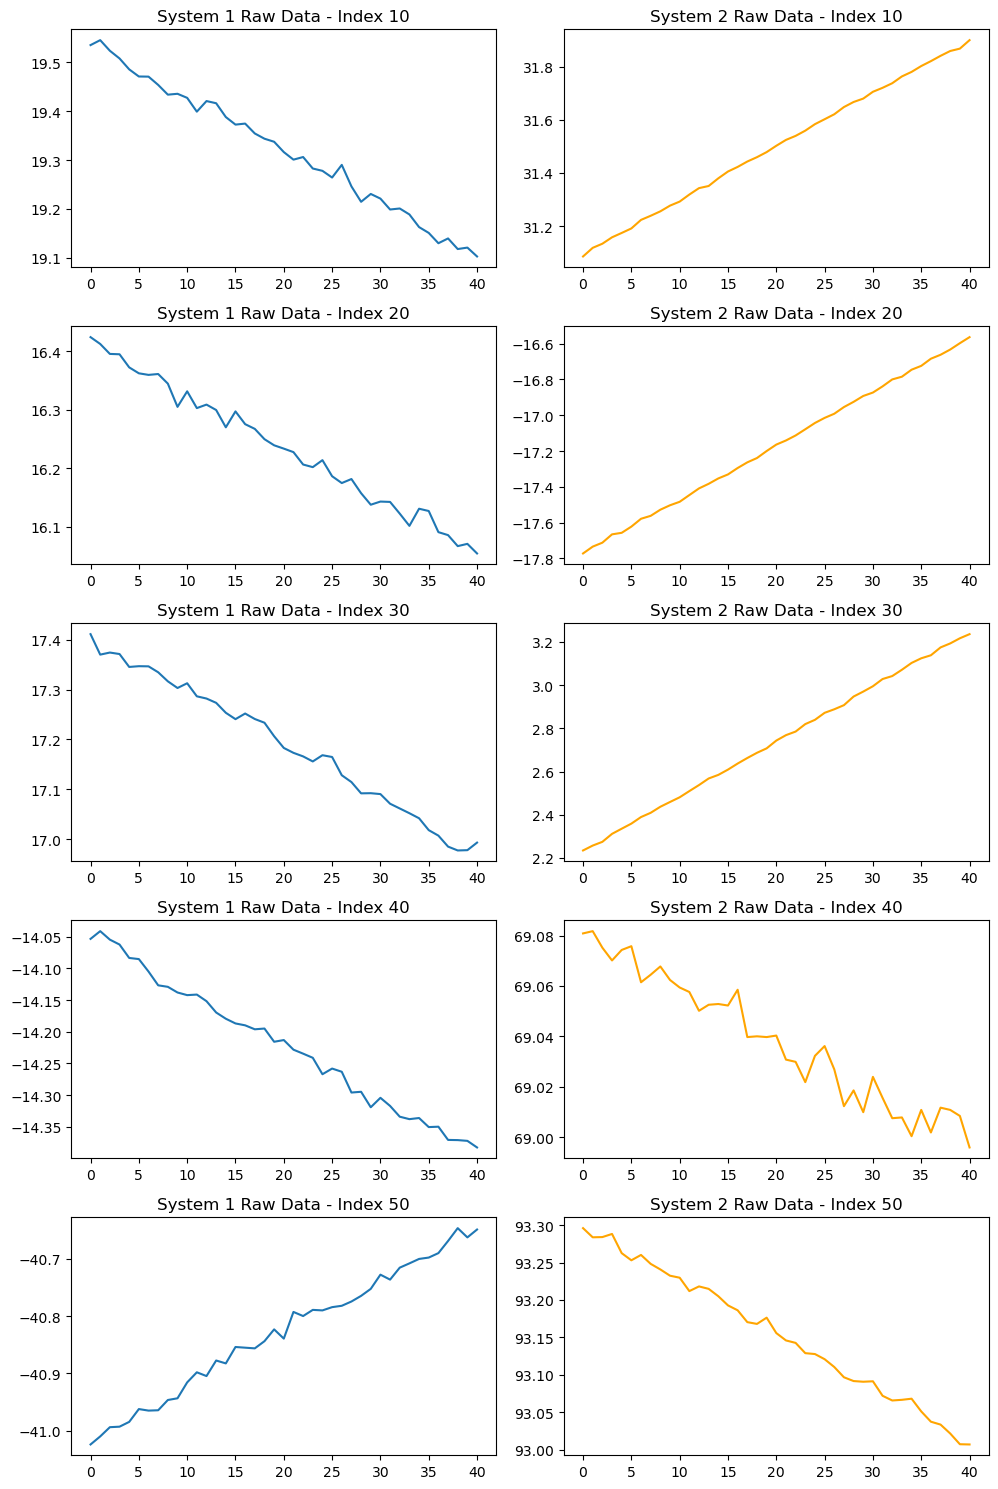

In [21]:
# Plotting in a grid of 5 rows and 2 columns
fig, axs = plt.subplots(5, 2, figsize=(10, 15))

# System 1 plots (first column)
A1_blood_cal_window.iloc[10, :].plot(ax=axs[0, 0], title='System 1 Raw Data - Index 10')
A1_blood_cal_window.iloc[20, :].plot(ax=axs[1, 0], title='System 1 Raw Data - Index 20')
A1_blood_cal_window.iloc[30, :].plot(ax=axs[2, 0], title='System 1 Raw Data - Index 30')
A1_blood_cal_window.iloc[40, :].plot(ax=axs[3, 0], title='System 1 Raw Data - Index 40')
A1_blood_cal_window.iloc[50, :].plot(ax=axs[4, 0], title='System 1 Raw Data - Index 50')

# System 2 plots (second column)
A2_blood_cal_window.iloc[10, :].plot(ax=axs[0, 1], title='System 2 Raw Data - Index 10', color = 'orange')
A2_blood_cal_window.iloc[20, :].plot(ax=axs[1, 1], title='System 2 Raw Data - Index 20', color = 'orange')
A2_blood_cal_window.iloc[30, :].plot(ax=axs[2, 1], title='System 2 Raw Data - Index 30', color = 'orange')
A2_blood_cal_window.iloc[40, :].plot(ax=axs[3, 1], title='System 2 Raw Data - Index 40', color = 'orange')
A2_blood_cal_window.iloc[50, :].plot(ax=axs[4, 1], title='System 2 Raw Data - Index 50', color = 'orange')

# Adjust layout
plt.tight_layout()
plt.show()

## 7.2. Visualize the windows of the raw data

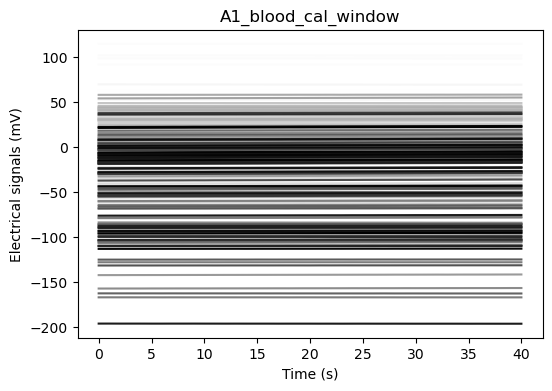

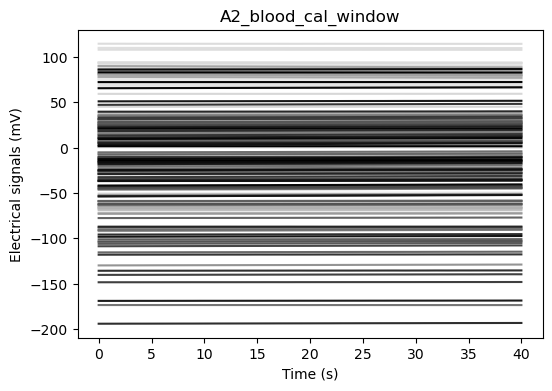

In [22]:
# # Plot all the time series from the window extraction
plot_all_time_series(A1_blood_cal_window, "A1_blood_cal_window")
plot_all_time_series(A2_blood_cal_window, "A2_blood_cal_window")

## 7.3 Visualization of the data centered

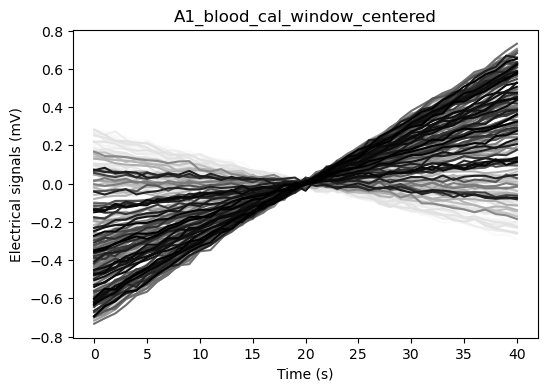

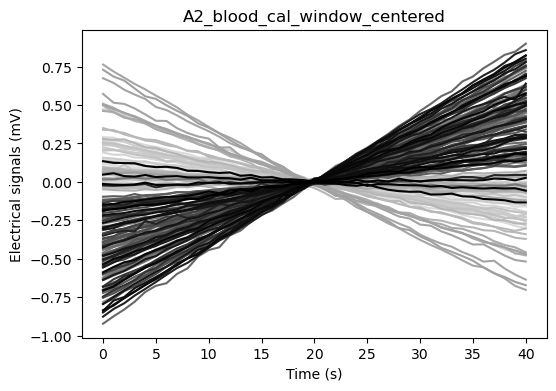

In [23]:
# By row: Each row has mean 0 (Using Nayeli's function to center the data)
# Plot all the time series centered from the window extraction
plot_all_time_series(center_data(A1_blood_cal_window), "A1_blood_cal_window_centered")
plot_all_time_series(center_data(A2_blood_cal_window), "A2_blood_cal_window_centered")

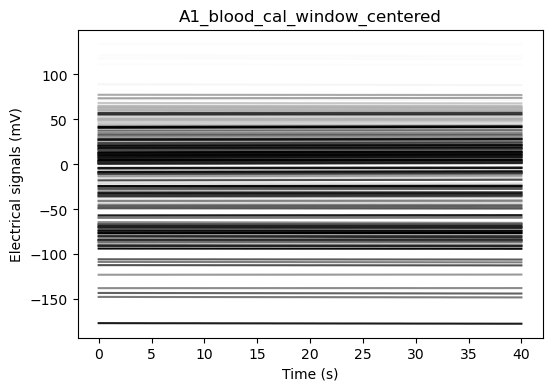

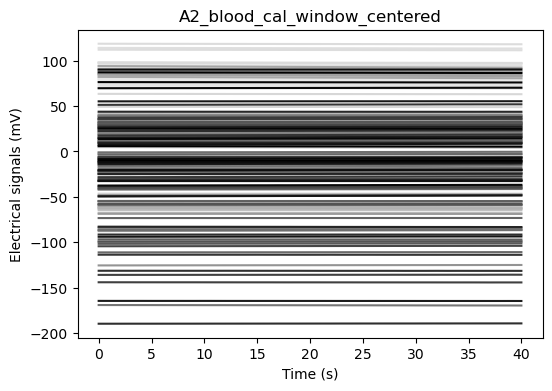

In [24]:
# By column: Each column has nean 0 (Using Jessie's function to center the data)
# Plot all the time series centered from the window extraction
plot_all_time_series(center_data_J(A1_blood_cal_window), "A1_blood_cal_window_centered")
plot_all_time_series(center_data_J(A2_blood_cal_window), "A2_blood_cal_window_centered")

## 7.4.1. Visualization of the data standardize over time stamps

Note: This standardize over timestamps, because this Machile Learning technique is ussually applied on columns (features) with different ranges to scale the data to have mean 0 and std 1.

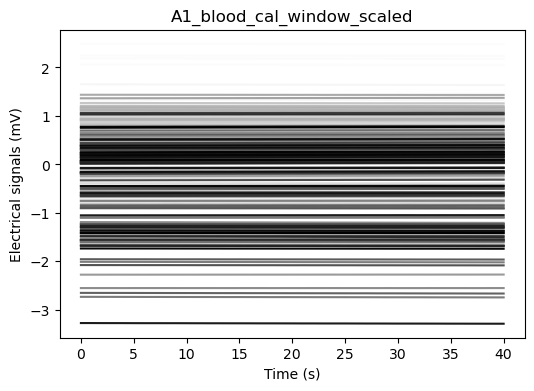

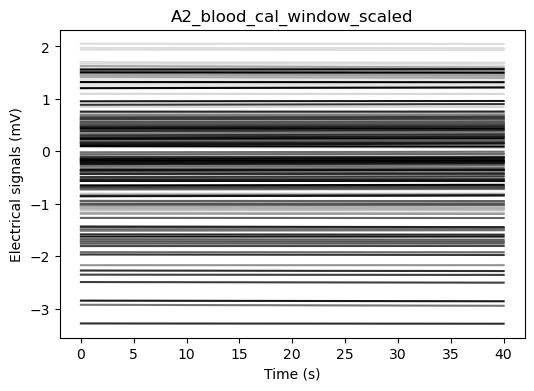

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

A1_blood_cal_window_scaler = preprocessing.StandardScaler().fit(A1_blood_cal_window)
A1_blood_cal_window_scaled = A1_blood_cal_window_scaler.transform(A1_blood_cal_window)
A1_blood_cal_window_scaled_df = pd.DataFrame(A1_blood_cal_window_scaled, columns=A1_blood_cal_window.columns)
A1_blood_cal_window_scaled_df.set_index(A1_blood_cal_window.index, inplace=True)
plot_all_time_series(A1_blood_cal_window_scaled_df, 'A1_blood_cal_window_scaled')
plt.show()

A2_blood_cal_window_scaler = preprocessing.StandardScaler().fit(A2_blood_cal_window)
A2_blood_cal_window_scaled = A2_blood_cal_window_scaler.transform(A2_blood_cal_window)
A2_blood_cal_window_scaled_df = pd.DataFrame(A2_blood_cal_window_scaled, columns=A2_blood_cal_window.columns)
A2_blood_cal_window_scaled_df.set_index(A2_blood_cal_window.index, inplace=True)
plot_all_time_series(A2_blood_cal_window_scaled_df, 'A2_blood_cal_window_scaled')
plt.show()

## 7.4.2. Visualization of the data standardize over TestIDs

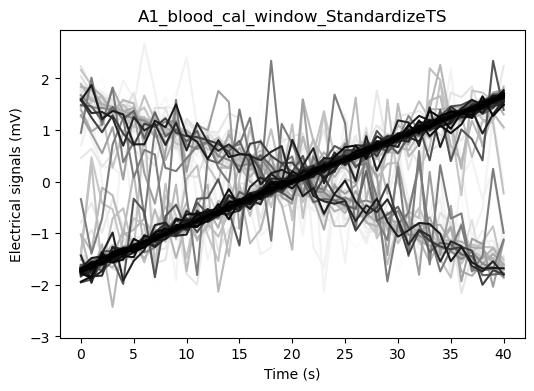

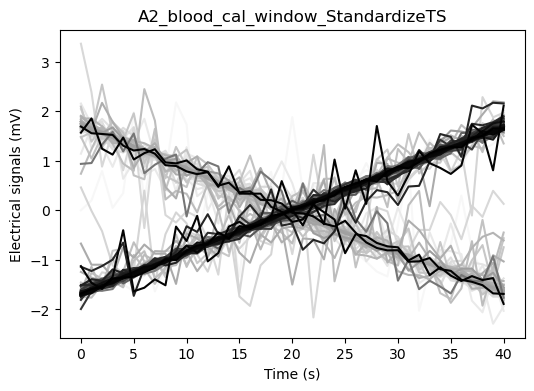

In [26]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn import metrics
# Scaler for time series. Scales time series so that their mean (resp. standard deviation) in each dimension is mu (resp. std).

scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series

A1_blood_cal_window_TS_scaled = scaler.fit_transform(A1_blood_cal_window)
A1_blood_cal_window_TS_scaled_reshape = A1_blood_cal_window_TS_scaled.reshape(208, 41)
A1_blood_cal_window_TS_scaled_df = pd.DataFrame(A1_blood_cal_window_TS_scaled_reshape, columns=A1_blood_cal_window.columns)
A1_blood_cal_window_TS_scaled_df.set_index(A1_blood_cal_window.index, inplace=True)
plot_all_time_series(A1_blood_cal_window_TS_scaled_df, 'A1_blood_cal_window_StandardizeTS')
plt.show()

A2_blood_cal_window_TS_scaled = scaler.fit_transform(A2_blood_cal_window)
A2_blood_cal_window_TS_scaled_reshape = A2_blood_cal_window_TS_scaled.reshape(208, 41)
A2_blood_cal_window_TS_scaled_df = pd.DataFrame(A2_blood_cal_window_TS_scaled_reshape, columns=A2_blood_cal_window.columns)
A2_blood_cal_window_TS_scaled_df.set_index(A2_blood_cal_window.index, inplace=True)
plot_all_time_series(A2_blood_cal_window_TS_scaled_df, 'A2_blood_cal_window_StandardizeTS')
plt.show()

## 7.5. Visualizations Start 0

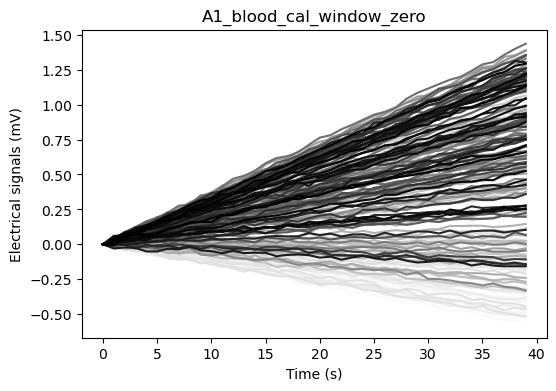

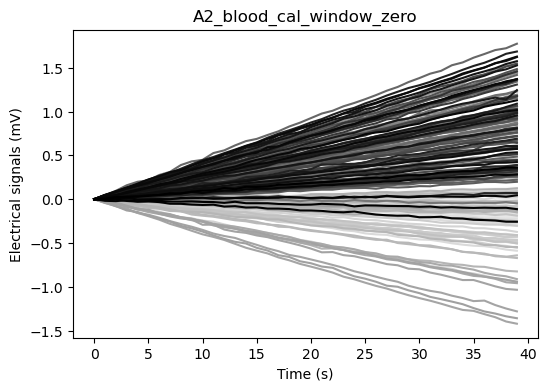

In [27]:
# Put the beginning of all sensor data at the same value (zero)
A1_blood_cal_window_zero = A1_blood_cal_window.iloc[:, 1:].sub(A1_blood_cal_window.iloc[:, 1], axis=0)
A2_blood_cal_window_zero = A2_blood_cal_window.iloc[:, 1:].sub(A2_blood_cal_window.iloc[:, 1], axis=0)
plot_all_time_series(A1_blood_cal_window_zero, 'A1_blood_cal_window_zero')
plot_all_time_series(A2_blood_cal_window_zero, 'A2_blood_cal_window_zero')

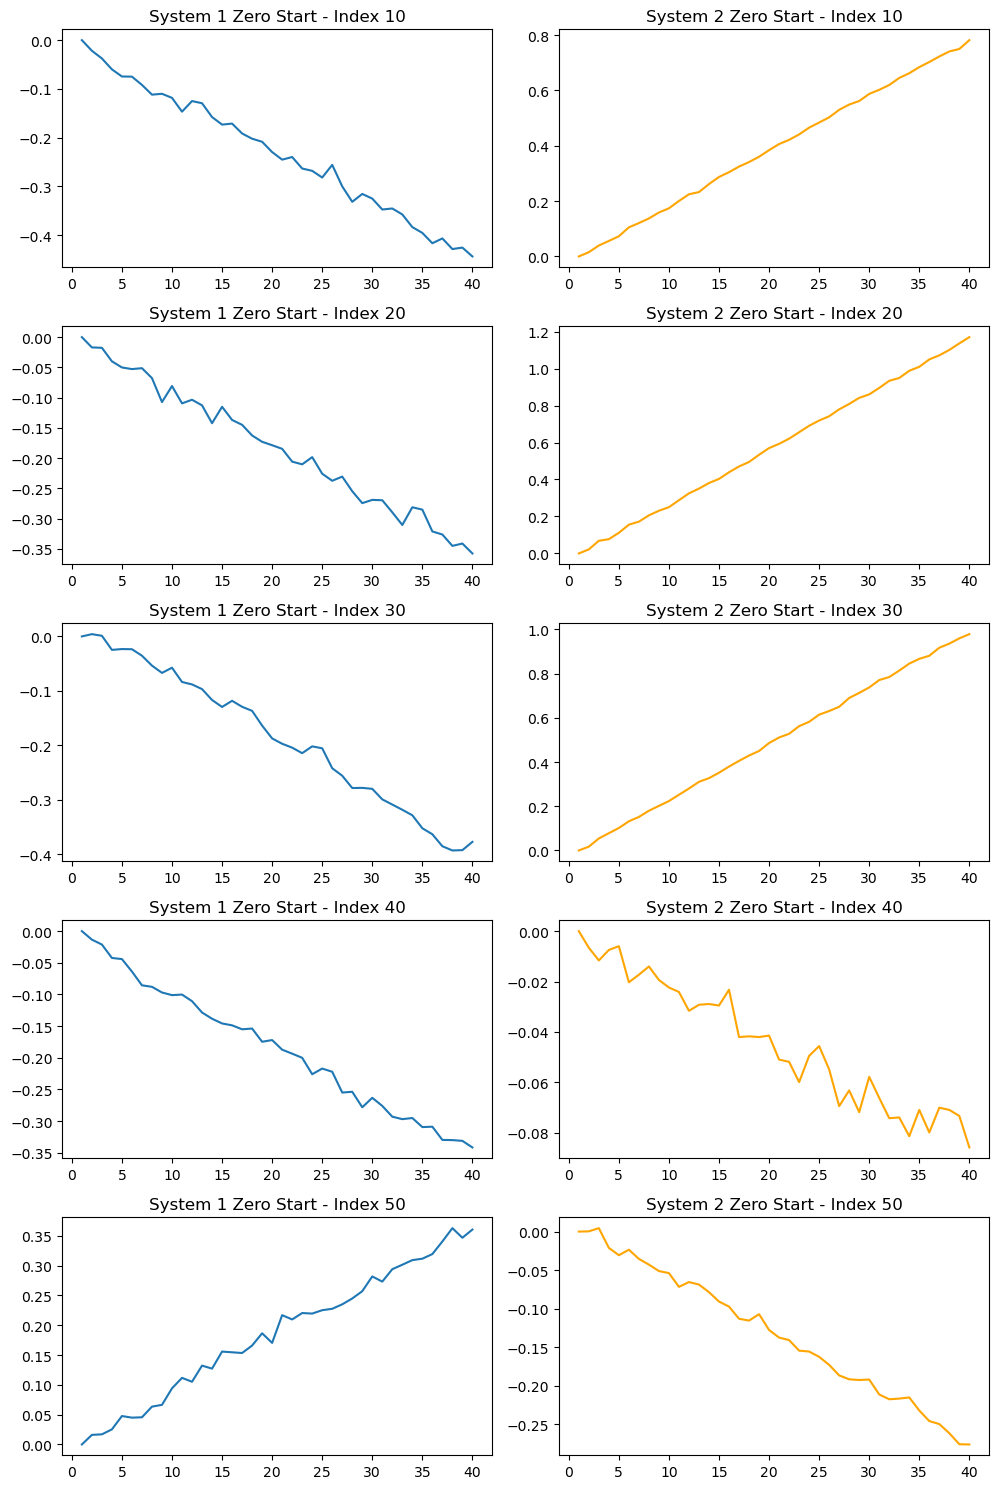

In [28]:
# Plotting in a grid of 5 rows and 2 columns
fig, axs = plt.subplots(5, 2, figsize=(10, 15))

# System 1 plots (first column)
A1_blood_cal_window_zero.iloc[10, :].plot(ax=axs[0, 0], title='System 1 Zero Start - Index 10')
A1_blood_cal_window_zero.iloc[20, :].plot(ax=axs[1, 0], title='System 1 Zero Start - Index 20')
A1_blood_cal_window_zero.iloc[30, :].plot(ax=axs[2, 0], title='System 1 Zero Start - Index 30')
A1_blood_cal_window_zero.iloc[40, :].plot(ax=axs[3, 0], title='System 1 Zero Start - Index 40')
A1_blood_cal_window_zero.iloc[50, :].plot(ax=axs[4, 0], title='System 1 Zero Start - Index 50')

# System 2 plots (second column)
A2_blood_cal_window_zero.iloc[10, :].plot(ax=axs[0, 1], title='System 2 Zero Start - Index 10', color = 'orange')
A2_blood_cal_window_zero.iloc[20, :].plot(ax=axs[1, 1], title='System 2 Zero Start - Index 20', color = 'orange')
A2_blood_cal_window_zero.iloc[30, :].plot(ax=axs[2, 1], title='System 2 Zero Start - Index 30', color = 'orange')
A2_blood_cal_window_zero.iloc[40, :].plot(ax=axs[3, 1], title='System 2 Zero Start - Index 40', color = 'orange')
A2_blood_cal_window_zero.iloc[50, :].plot(ax=axs[4, 1], title='System 2 Zero Start - Index 50', color = 'orange')

# Adjust layout
plt.tight_layout()
plt.show()

# 7.6. Visualizing the Differentiated Time Series

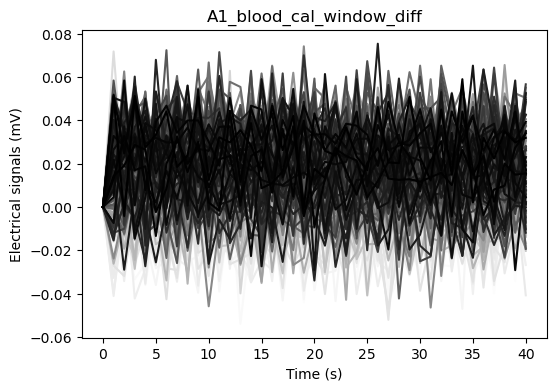

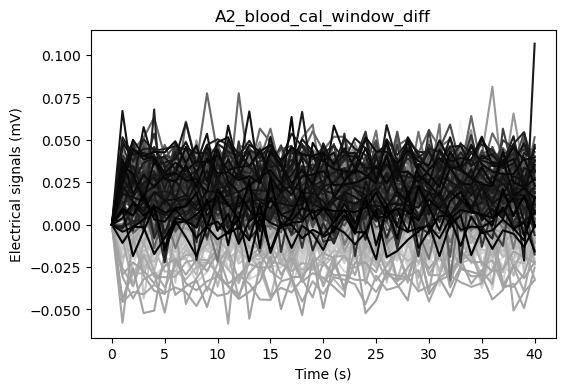

In [29]:
# Usually differencing makes the time series stationary
A1_blood_cal_window_diff = A1_blood_cal_window.diff(axis=1)
A1_blood_cal_window_diff = A1_blood_cal_window_diff.fillna(0)
A2_blood_cal_window_diff = A2_blood_cal_window.diff(axis=1)
A2_blood_cal_window_diff = A2_blood_cal_window_diff.fillna(0)

plot_all_time_series(A1_blood_cal_window_diff, 'A1_blood_cal_window_diff')
plot_all_time_series(A2_blood_cal_window_diff, 'A2_blood_cal_window_diff')

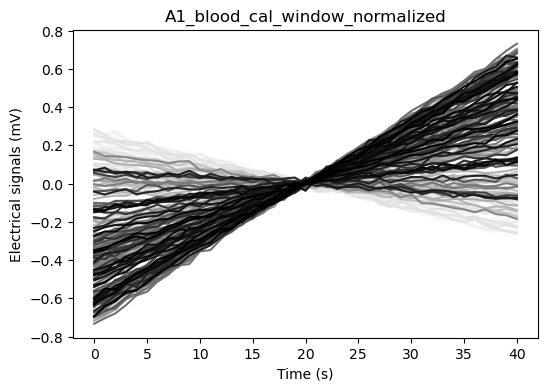

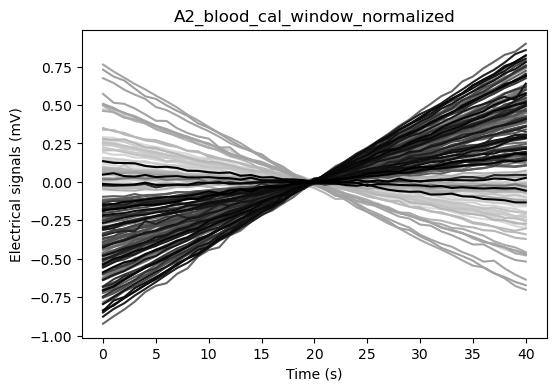

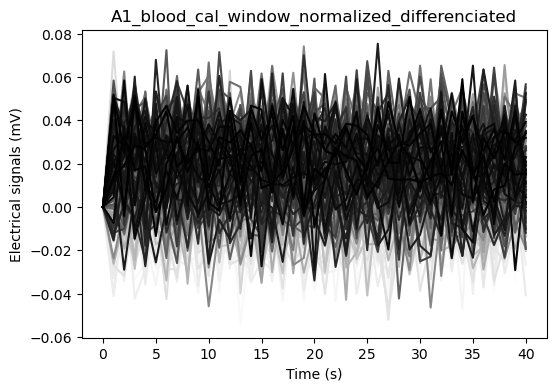

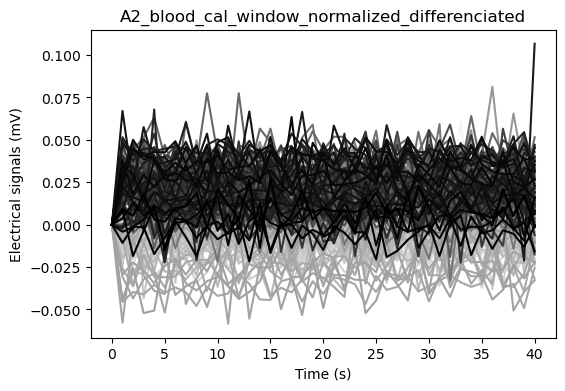

In [30]:
# Normalize the time series by subtracting the mean of each row
A1_blood_cal_window_normalized = A1_blood_cal_window.sub(A1_blood_cal_window.mean(axis=1), axis=0)
A2_blood_cal_window_normalized = A2_blood_cal_window.sub(A2_blood_cal_window.mean(axis=1), axis=0)

plot_all_time_series(A1_blood_cal_window_normalized, 'A1_blood_cal_window_normalized')
plot_all_time_series(A2_blood_cal_window_normalized, 'A2_blood_cal_window_normalized')

# Differentiate the normalized time series along the columns (axis=1)
A1_blood_cal_window_NormDiff = A1_blood_cal_window_normalized.diff(axis=1).fillna(0)
A2_blood_cal_window_NormDiff = A2_blood_cal_window_normalized.diff(axis=1).fillna(0)

plot_all_time_series(A1_blood_cal_window_NormDiff, 'A1_blood_cal_window_normalized_differenciated')
plot_all_time_series(A2_blood_cal_window_NormDiff, 'A2_blood_cal_window_normalized_differenciated')

## Comparison of individual samples

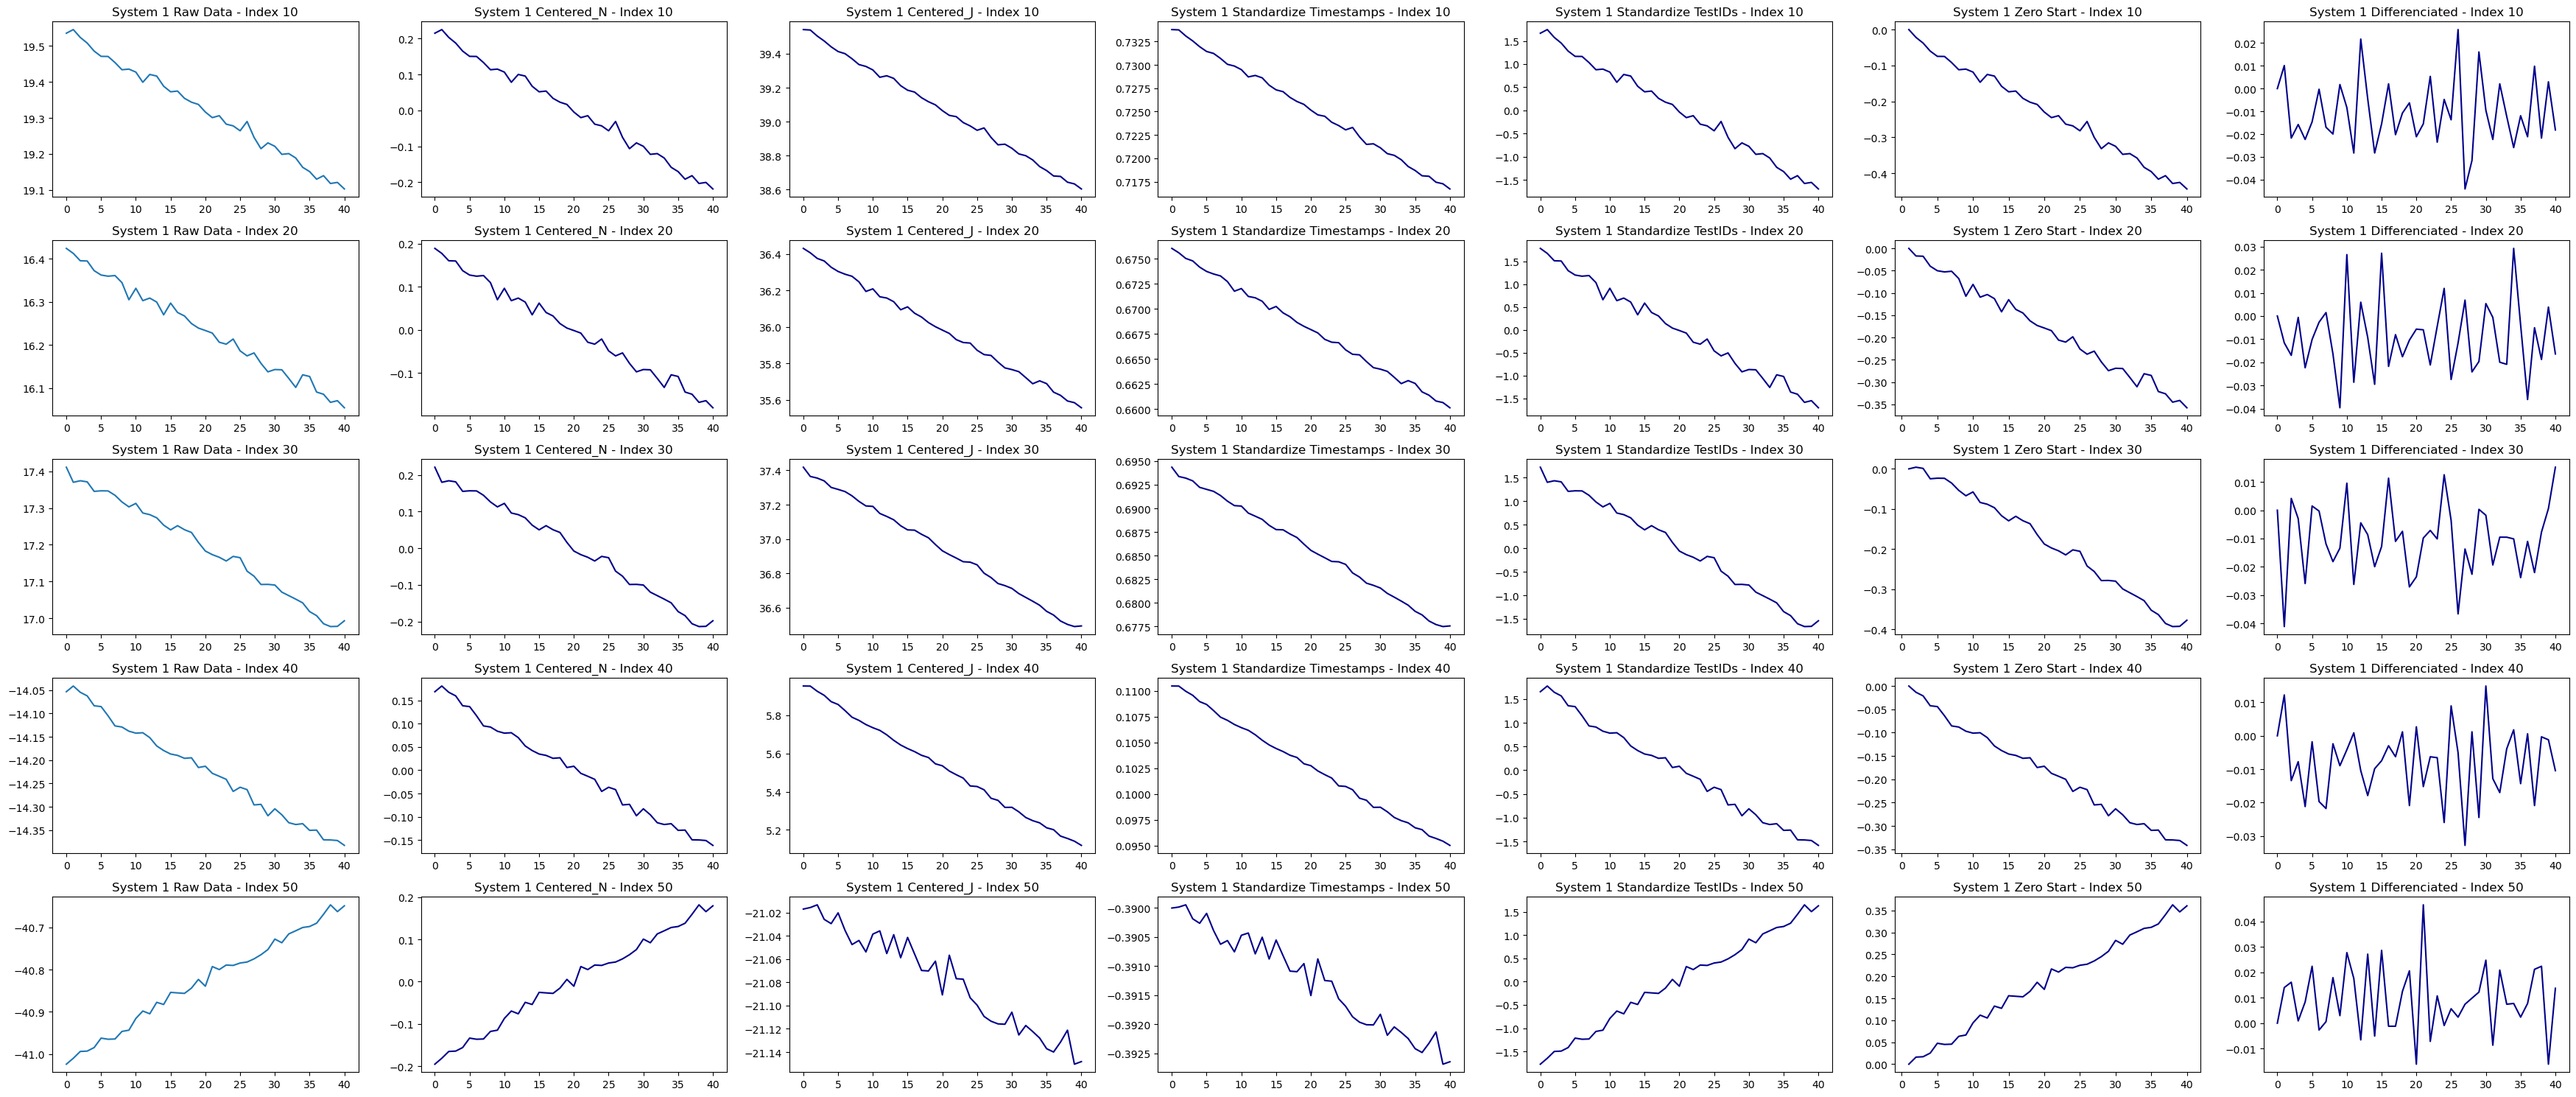

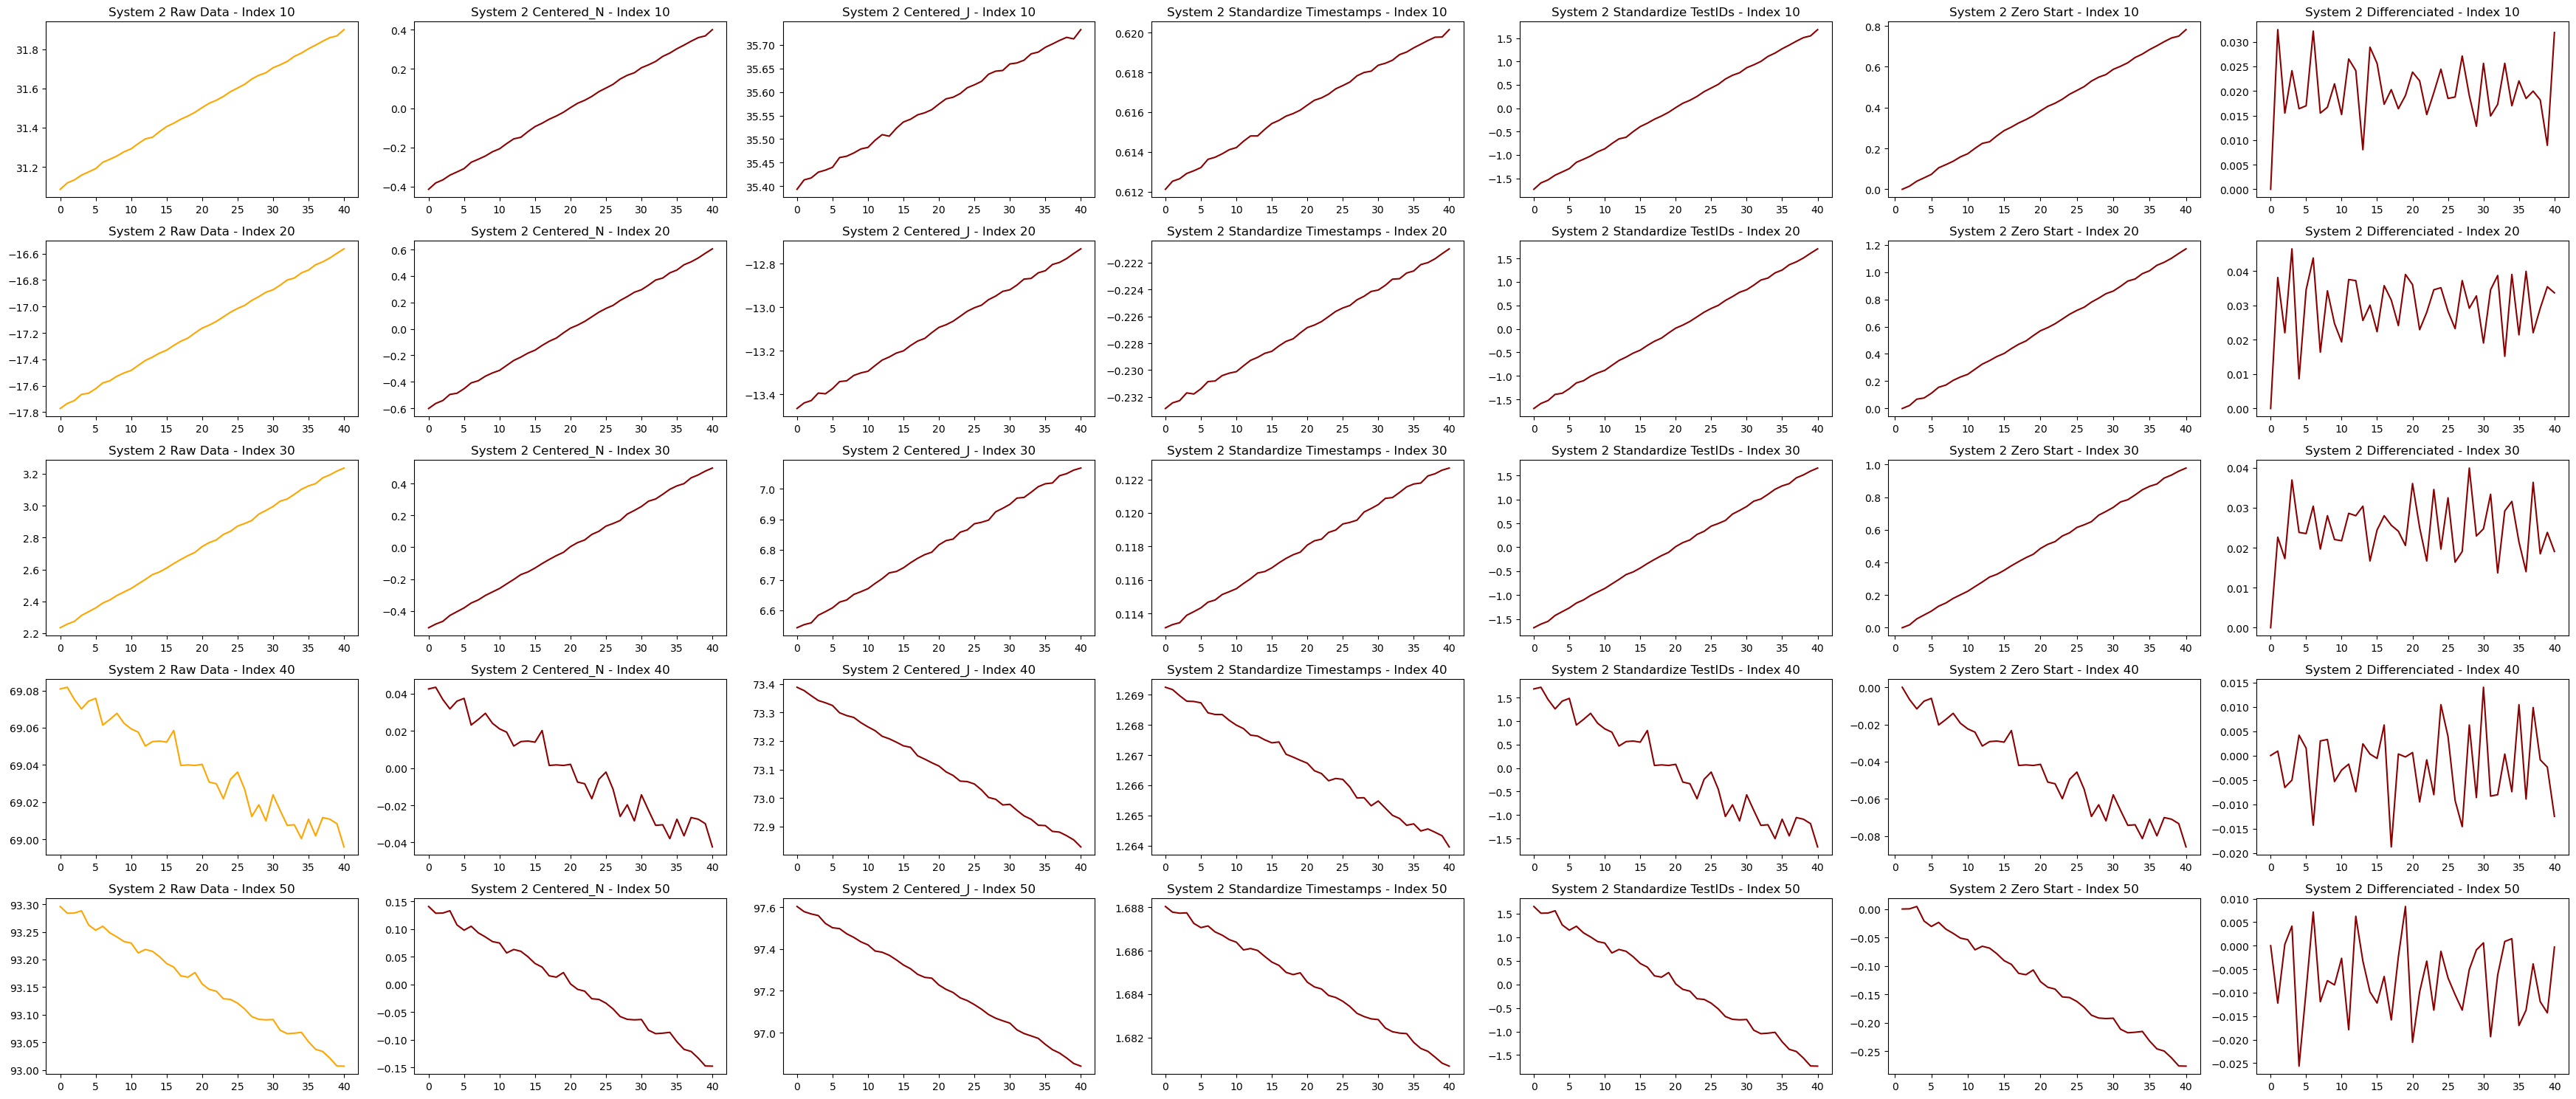

In [31]:
# Plotting in a grid of 5 rows and 7 columns
fig, axs = plt.subplots(5, 7, figsize=(35, 15))
#fig, axs = plt.subplots(5, 6, figsize=(35, 15))

# System 1 Raw Data plots 
A1_blood_cal_window.iloc[10, :].plot(ax=axs[0, 0], title='System 1 Raw Data - Index 10')
A1_blood_cal_window.iloc[20, :].plot(ax=axs[1, 0], title='System 1 Raw Data - Index 20')
A1_blood_cal_window.iloc[30, :].plot(ax=axs[2, 0], title='System 1 Raw Data - Index 30')
A1_blood_cal_window.iloc[40, :].plot(ax=axs[3, 0], title='System 1 Raw Data - Index 40')
A1_blood_cal_window.iloc[50, :].plot(ax=axs[4, 0], title='System 1 Raw Data - Index 50')

# System 1 Centered Data plots 
center_data(A1_blood_cal_window).iloc[10, :].plot(ax=axs[0, 1], title='System 1 Centered_N - Index 10', color = 'darkblue')
center_data(A1_blood_cal_window).iloc[20, :].plot(ax=axs[1, 1], title='System 1 Centered_N - Index 20', color = 'darkblue')
center_data(A1_blood_cal_window).iloc[30, :].plot(ax=axs[2, 1], title='System 1 Centered_N - Index 30', color = 'darkblue')
center_data(A1_blood_cal_window).iloc[40, :].plot(ax=axs[3, 1], title='System 1 Centered_N - Index 40', color = 'darkblue')
center_data(A1_blood_cal_window).iloc[50, :].plot(ax=axs[4, 1], title='System 1 Centered_N - Index 50', color = 'darkblue')

# System 1 Centered Data plots 
center_data_J(A1_blood_cal_window).iloc[10, :].plot(ax=axs[0, 2], title='System 1 Centered_J - Index 10', color = 'darkblue')
center_data_J(A1_blood_cal_window).iloc[20, :].plot(ax=axs[1, 2], title='System 1 Centered_J - Index 20', color = 'darkblue')
center_data_J(A1_blood_cal_window).iloc[30, :].plot(ax=axs[2, 2], title='System 1 Centered_J - Index 30', color = 'darkblue')
center_data_J(A1_blood_cal_window).iloc[40, :].plot(ax=axs[3, 2], title='System 1 Centered_J - Index 40', color = 'darkblue')
center_data_J(A1_blood_cal_window).iloc[50, :].plot(ax=axs[4, 2], title='System 1 Centered_J - Index 50', color = 'darkblue')

# System 1 Standardize Over time stamps plots 
A1_blood_cal_window_scaled_df.iloc[10, :].plot(ax=axs[0, 3], title='System 1 Standardize Timestamps - Index 10', color = 'darkblue')
A1_blood_cal_window_scaled_df.iloc[20, :].plot(ax=axs[1, 3], title='System 1 Standardize Timestamps - Index 20', color = 'darkblue')
A1_blood_cal_window_scaled_df.iloc[30, :].plot(ax=axs[2, 3], title='System 1 Standardize Timestamps - Index 30', color = 'darkblue')
A1_blood_cal_window_scaled_df.iloc[40, :].plot(ax=axs[3, 3], title='System 1 Standardize Timestamps - Index 40', color = 'darkblue')
A1_blood_cal_window_scaled_df.iloc[50, :].plot(ax=axs[4, 3], title='System 1 Standardize Timestamps - Index 50', color = 'darkblue')

# System 1 Standardize Over TestID's plots
A1_blood_cal_window_TS_scaled_df.iloc[10, :].plot(ax=axs[0, 4], title='System 1 Standardize TestIDs - Index 10', color = 'darkblue')
A1_blood_cal_window_TS_scaled_df.iloc[20, :].plot(ax=axs[1, 4], title='System 1 Standardize TestIDs - Index 20', color = 'darkblue')
A1_blood_cal_window_TS_scaled_df.iloc[30, :].plot(ax=axs[2, 4], title='System 1 Standardize TestIDs - Index 30', color = 'darkblue')
A1_blood_cal_window_TS_scaled_df.iloc[40, :].plot(ax=axs[3, 4], title='System 1 Standardize TestIDs - Index 40', color = 'darkblue')
A1_blood_cal_window_TS_scaled_df.iloc[50, :].plot(ax=axs[4, 4], title='System 1 Standardize TestIDs - Index 50', color = 'darkblue')

# System 1 Zero Start plots
A1_blood_cal_window_zero.iloc[10, :].plot(ax=axs[0, 5], title='System 1 Zero Start - Index 10', color = 'darkblue')
A1_blood_cal_window_zero.iloc[20, :].plot(ax=axs[1, 5], title='System 1 Zero Start - Index 20', color = 'darkblue')
A1_blood_cal_window_zero.iloc[30, :].plot(ax=axs[2, 5], title='System 1 Zero Start - Index 30', color = 'darkblue')
A1_blood_cal_window_zero.iloc[40, :].plot(ax=axs[3, 5], title='System 1 Zero Start - Index 40', color = 'darkblue')
A1_blood_cal_window_zero.iloc[50, :].plot(ax=axs[4, 5], title='System 1 Zero Start - Index 50', color = 'darkblue')

# System 1 Differenciated plots (second column)
A1_blood_cal_window_diff.iloc[10, :].plot(ax=axs[0, 6], title='System 1 Differenciated - Index 10', color = 'darkblue')
A1_blood_cal_window_diff.iloc[20, :].plot(ax=axs[1, 6], title='System 1 Differenciated - Index 20', color = 'darkblue')
A1_blood_cal_window_diff.iloc[30, :].plot(ax=axs[2, 6], title='System 1 Differenciated - Index 30', color = 'darkblue')
A1_blood_cal_window_diff.iloc[40, :].plot(ax=axs[3, 6], title='System 1 Differenciated - Index 40', color = 'darkblue')
A1_blood_cal_window_diff.iloc[50, :].plot(ax=axs[4, 6], title='System 1 Differenciated - Index 50', color = 'darkblue')

# System 1 Normalization + Differenciation plots (second column)
#A1_blood_cal_window_NormDiff.iloc[10, :].plot(ax=axs[0, 7], title='System 1 Norm + Diff - Index 10', color = 'darkblue')
#A1_blood_cal_window_NormDiff.iloc[20, :].plot(ax=axs[1, 7], title='System 1 Norm + Diff - Index 20', color = 'darkblue')
#A1_blood_cal_window_NormDiff.iloc[30, :].plot(ax=axs[2, 7], title='System 1 Norm + Diff - Index 30', color = 'darkblue')
#A1_blood_cal_window_NormDiff.iloc[40, :].plot(ax=axs[3, 7], title='System 1 Norm + Diff - Index 40', color = 'darkblue')
#A1_blood_cal_window_NormDiff.iloc[50, :].plot(ax=axs[4, 7], title='System 1 Norm + Diff - Index 50', color = 'darkblue')

# Adjust layout
plt.tight_layout()
plt.show()

# --- System 2 --- 

# Plotting in a grid of 5 rows and 7 columns
fig, axs = plt.subplots(5, 7, figsize=(35, 15))
#fig, axs = plt.subplots(5, 6, figsize=(35, 15))
# System 1 Raw Data plots
A2_blood_cal_window.iloc[10, :].plot(ax=axs[0, 0], title='System 2 Raw Data - Index 10', color = 'orange')
A2_blood_cal_window.iloc[20, :].plot(ax=axs[1, 0], title='System 2 Raw Data - Index 20', color = 'orange')
A2_blood_cal_window.iloc[30, :].plot(ax=axs[2, 0], title='System 2 Raw Data - Index 30', color = 'orange')
A2_blood_cal_window.iloc[40, :].plot(ax=axs[3, 0], title='System 2 Raw Data - Index 40', color = 'orange')
A2_blood_cal_window.iloc[50, :].plot(ax=axs[4, 0], title='System 2 Raw Data - Index 50', color = 'orange')

# System 1 Centered Data plots
center_data(A2_blood_cal_window).iloc[10, :].plot(ax=axs[0, 1], title='System 2 Centered_N - Index 10', color = 'darkred')
center_data(A2_blood_cal_window).iloc[20, :].plot(ax=axs[1, 1], title='System 2 Centered_N - Index 20', color = 'darkred')
center_data(A2_blood_cal_window).iloc[30, :].plot(ax=axs[2, 1], title='System 2 Centered_N - Index 30', color = 'darkred')
center_data(A2_blood_cal_window).iloc[40, :].plot(ax=axs[3, 1], title='System 2 Centered_N - Index 40', color = 'darkred')
center_data(A2_blood_cal_window).iloc[50, :].plot(ax=axs[4, 1], title='System 2 Centered_N - Index 50', color = 'darkred')

# System 1 Centered Data plots
center_data_J(A2_blood_cal_window).iloc[10, :].plot(ax=axs[0, 2], title='System 2 Centered_J - Index 10', color = 'darkred')
center_data_J(A2_blood_cal_window).iloc[20, :].plot(ax=axs[1, 2], title='System 2 Centered_J - Index 20', color = 'darkred')
center_data_J(A2_blood_cal_window).iloc[30, :].plot(ax=axs[2, 2], title='System 2 Centered_J - Index 30', color = 'darkred')
center_data_J(A2_blood_cal_window).iloc[40, :].plot(ax=axs[3, 2], title='System 2 Centered_J - Index 40', color = 'darkred')
center_data_J(A2_blood_cal_window).iloc[50, :].plot(ax=axs[4, 2], title='System 2 Centered_J - Index 50', color = 'darkred')

# System 1 Standardize Over time stamps plots
A2_blood_cal_window_scaled_df.iloc[10, :].plot(ax=axs[0, 3], title='System 2 Standardize Timestamps - Index 10', color = 'darkred')
A2_blood_cal_window_scaled_df.iloc[20, :].plot(ax=axs[1, 3], title='System 2 Standardize Timestamps - Index 20', color = 'darkred')
A2_blood_cal_window_scaled_df.iloc[30, :].plot(ax=axs[2, 3], title='System 2 Standardize Timestamps - Index 30', color = 'darkred')
A2_blood_cal_window_scaled_df.iloc[40, :].plot(ax=axs[3, 3], title='System 2 Standardize Timestamps - Index 40', color = 'darkred')
A2_blood_cal_window_scaled_df.iloc[50, :].plot(ax=axs[4, 3], title='System 2 Standardize Timestamps - Index 50', color = 'darkred')

# System 1 Standardize Over TestID's plots
A2_blood_cal_window_TS_scaled_df.iloc[10, :].plot(ax=axs[0, 4], title='System 2 Standardize TestIDs - Index 10', color = 'darkred')
A2_blood_cal_window_TS_scaled_df.iloc[20, :].plot(ax=axs[1, 4], title='System 2 Standardize TestIDs - Index 20', color = 'darkred')
A2_blood_cal_window_TS_scaled_df.iloc[30, :].plot(ax=axs[2, 4], title='System 2 Standardize TestIDs - Index 30', color = 'darkred')
A2_blood_cal_window_TS_scaled_df.iloc[40, :].plot(ax=axs[3, 4], title='System 2 Standardize TestIDs - Index 40', color = 'darkred')
A2_blood_cal_window_TS_scaled_df.iloc[50, :].plot(ax=axs[4, 4], title='System 2 Standardize TestIDs - Index 50', color = 'darkred')

# System 1 Zero Start plots 
A2_blood_cal_window_zero.iloc[10, :].plot(ax=axs[0, 5], title='System 2 Zero Start - Index 10', color = 'darkred')
A2_blood_cal_window_zero.iloc[20, :].plot(ax=axs[1, 5], title='System 2 Zero Start - Index 20', color = 'darkred')
A2_blood_cal_window_zero.iloc[30, :].plot(ax=axs[2, 5], title='System 2 Zero Start - Index 30', color = 'darkred')
A2_blood_cal_window_zero.iloc[40, :].plot(ax=axs[3, 5], title='System 2 Zero Start - Index 40', color = 'darkred')
A2_blood_cal_window_zero.iloc[50, :].plot(ax=axs[4, 5], title='System 2 Zero Start - Index 50', color = 'darkred')

# System 1 Differenciated plots
A2_blood_cal_window_diff.iloc[10, :].plot(ax=axs[0, 6], title='System 2 Differenciated - Index 10', color = 'darkred')
A2_blood_cal_window_diff.iloc[20, :].plot(ax=axs[1, 6], title='System 2 Differenciated - Index 20', color = 'darkred')
A2_blood_cal_window_diff.iloc[30, :].plot(ax=axs[2, 6], title='System 2 Differenciated - Index 30', color = 'darkred')
A2_blood_cal_window_diff.iloc[40, :].plot(ax=axs[3, 6], title='System 2 Differenciated - Index 40', color = 'darkred')
A2_blood_cal_window_diff.iloc[50, :].plot(ax=axs[4, 6], title='System 2 Differenciated - Index 50', color = 'darkred')

# System 1 Normalization + Differenciation plots (second column)
#A2_blood_cal_window_NormDiff.iloc[10, :].plot(ax=axs[0, 7], title='System 2 Norm + Diff - Index 10', color = 'darkblue')
#A2_blood_cal_window_NormDiff.iloc[20, :].plot(ax=axs[1, 7], title='System 2 Norm + Diff - Index 20', color = 'darkblue')
#A2_blood_cal_window_NormDiff.iloc[30, :].plot(ax=axs[2, 7], title='System 2 Norm + Diff - Index 30', color = 'darkblue')
#A2_blood_cal_window_NormDiff.iloc[40, :].plot(ax=axs[3, 7], title='System 2 Norm + Diff - Index 40', color = 'darkblue')
#A2_blood_cal_window_NormDiff.iloc[50, :].plot(ax=axs[4, 7], title='System 2 Norm + Diff - Index 50', color = 'darkblue')

# Adjust layout
plt.tight_layout()
plt.show()

# 8. Functional Principal Components

In [32]:
def perform_functional_pca(data_matrix, y_axis_min=None, y_axis_max=None, color_fpc1=None, color_fpc2=None):
    """
    Performs Functional Principal Component Analysis (FPCA) on a given data matrix and plots the results.

    Parameters:
    data_matrix (pd.DataFrame): A pandas DataFrame where each row represents a time series and each column represents a time point.
    y_axis_min (float, optional): The minimum value for the y-axis in the plots. Defaults to None.
    y_axis_max (float, optional): The maximum value for the y-axis in the plots. Defaults to None.
    color_fpc1 (str, optional): The color for the first functional principal component plot. Defaults to None.
    color_fpc2 (str, optional): The color for the second functional principal component plot. Defaults to None.

    Returns:
    None

    Prints:
    - The explained variance ratio of the first and second functional principal components.
    - The functional principal component scores for each time series.
    - The index and TestID of the time series contributing most to the first and second principal components.

    Plots:
    - The first and second functional principal components.
    - The individual plots of the first and second functional principal components.
    """
    fd = FDataGrid(data_matrix=data_matrix, grid_points=data_matrix.columns.astype(float))

    # Apply Functional PCA
    fpca = FPCA(n_components=2, centering=True)
    fpca.fit(fd)
    pc_scores = fpca.transform(fd)

    # Explain variance ratio
    print('Explain variance FPC1 (%): ', fpca.explained_variance_ratio_[0] * 100)
    print('Explain variance FPC2 (%): ', fpca.explained_variance_ratio_[1] * 100)

    # --- Loadings ---
    # Extract the principal components (loadings)
    principal_components = fpca.components_

    # Extract loadings for each time point from the first and second principal components
    loadings_pc1 = principal_components.data_matrix[0, :, 0]  # Loadings for the first PC
    loadings_pc2 = principal_components.data_matrix[1, :, 0]  # Loadings for the second PC
    loadings_df = pd.DataFrame({
    'PC1_Loadings': loadings_pc1,
    'PC2_Loadings': loadings_pc2}, index=[f'TimePoint_{i}' for i in range(data_matrix.shape[1])])
    #print("\nLoadings:\n", loadings_df)

    # --- Scores ---
    # Print the scores to see contributions of each time series to each principal component
    pc_scores_df = pd.DataFrame(pc_scores, columns=['PC1_Scores', 'PC2_Scores'],
                                index=[data_matrix.index[i] for i in range(data_matrix.shape[0])])
    print("FPC Scores:\n", pc_scores_df)

    # Identify which time series (functional data object) contributes the most to each principal component
    max_contribution_index_pc1 = np.argmax(np.abs(pc_scores[:, 0]))  # Index of the maximum absolute score in the first PC
    max_contribution_index_pc2 = np.argmax(np.abs(pc_scores[:, 1]))  # Index of the maximum absolute score in the second PC

    print(f'The time series contributing most to PC1 is at index {max_contribution_index_pc1} with TestID {data_matrix.index[max_contribution_index_pc1]}')
    print(f'The time series contributing most to PC2 is at index {max_contribution_index_pc2} with TestID {data_matrix.index[max_contribution_index_pc2]}')

    # --- Plotting Principal Components ---
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))

    # Both Functional PC's
    axs[0].plot(fpca.components_[0].grid_points[0], fpca.components_[0].data_matrix[0].flatten(), linestyle='-', label='Component 1', color = color_fpc1)
    axs[0].plot(fpca.components_[1].grid_points[0], fpca.components_[1].data_matrix[0].flatten(), linestyle='-', label='Component 2', color = color_fpc2)
    axs[0].set_title("Functional Principal Components")
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Functional PC Values')
    axs[0].legend()
    axs[0].grid(False)
    axs[0].set_ylim(y_axis_min, y_axis_max)

    # FPC1
    axs[1].plot(fpca.components_[0].grid_points[0], fpca.components_[0].data_matrix[0].flatten(), linestyle='-', label='Component 1', color = color_fpc1)
    axs[1].set_title("Functional Component 1")
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('')
    axs[1].legend()
    axs[1].grid(False)
    axs[1].set_ylim(y_axis_min, y_axis_max)

    # FPC2
    axs[2].plot(fpca.components_[1].grid_points[0], fpca.components_[1].data_matrix[0].flatten(), linestyle='-', label='Component 2', color = color_fpc2)
    axs[2].set_title("Functional Component 2")
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('')
    axs[2].legend()
    axs[2].grid(False)
    axs[2].set_ylim(y_axis_min, y_axis_max)

    # Adjust layout
    plt.tight_layout()

    # Show the plot
    plt.show()
    return fpca

In [33]:
# Note: For the following plots we can adjust the y-axis limit with the parameters y_axis_min and y_axis_max from the function perform_functional_pca().
# If these parameters are not provided then the plots will display the default range, however, we should be aware of this.
# For instance: perform_functional_pca(A1_blood_cal_window, y_axis_min=-0.6, y_axis_max=0.6)

Explain variance FPC1 (%):  99.99904252431632
Explain variance FPC2 (%):  0.0009541052218730671
FPC Scores:
           PC1_Scores  PC2_Scores
12414202 -499.793787    0.791788
12414210 -556.414625    0.964254
12414251 -520.084647    0.879309
12414261 -516.926217    0.759253
12416098 -478.038719    0.596846
...              ...         ...
12624887  -66.202726   -1.342516
12624889  -87.697253   -1.543550
12624890  -31.326830   -0.387007
12479777  482.438629   -0.231973
12537664 -259.789146   -1.234510

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 188 with TestID 12572826
The time series contributing most to PC2 is at index 9 with TestID 12464486


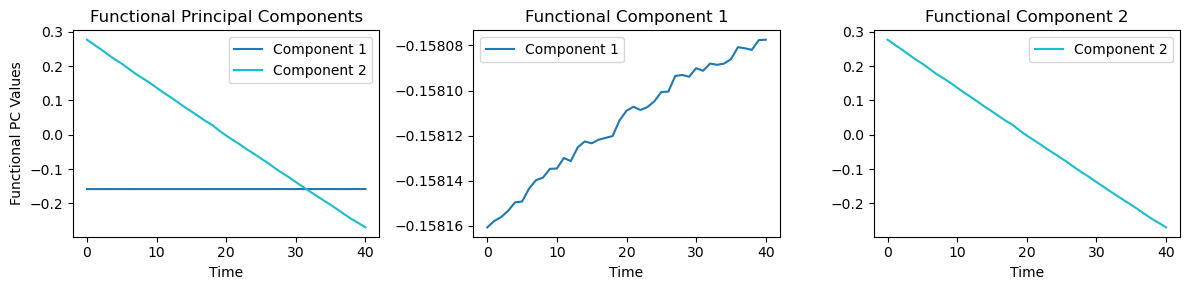

FDataGrid(
    array([[[-20.00687751],
            [-19.99419187],
            [-19.9804331 ],
            [-19.96700361],
            [-19.95501293],
            [-19.9419146 ],
            [-19.92949456],
            [-19.91672299],
            [-19.90238984],
            [-19.88952633],
            [-19.8771578 ],
            [-19.86233106],
            [-19.84941193],
            [-19.83850589],
            [-19.82375265],
            [-19.81258942],
            [-19.79956186],
            [-19.78656   ],
            [-19.77361752],
            [-19.76146315],
            [-19.74851986],
            [-19.73620853],
            [-19.72316364],
            [-19.71197842],
            [-19.69689999],
            [-19.68488471],
            [-19.6727712 ],
            [-19.66123252],
            [-19.64909759],
            [-19.63657675],
            [-19.62219914],
            [-19.61123525],
            [-19.59850763],
            [-19.58586486],
            [-19.57250294],
         

In [33]:
#A1_blood_cal_window.to_csv('A1_blood_cal_window.csv', index=False)
fpca_A1_blood_cal_window_check = perform_functional_pca(A1_blood_cal_window, color_fpc1='tab:blue', color_fpc2='tab:cyan')
fpca_A1_blood_cal_window_check.mean_

## Raw Data - Cal Window: System 1/2 - Blood

Explain variance FPC1 (%):  99.99904252431632
Explain variance FPC2 (%):  0.0009541052218730671
FPC Scores:
           PC1_Scores  PC2_Scores
12414202 -499.793787    0.791788
12414210 -556.414625    0.964254
12414251 -520.084647    0.879309
12414261 -516.926217    0.759253
12416098 -478.038719    0.596846
...              ...         ...
12624887  -66.202726   -1.342516
12624889  -87.697253   -1.543550
12624890  -31.326830   -0.387007
12479777  482.438629   -0.231973
12537664 -259.789146   -1.234510

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 188 with TestID 12572826
The time series contributing most to PC2 is at index 9 with TestID 12464486


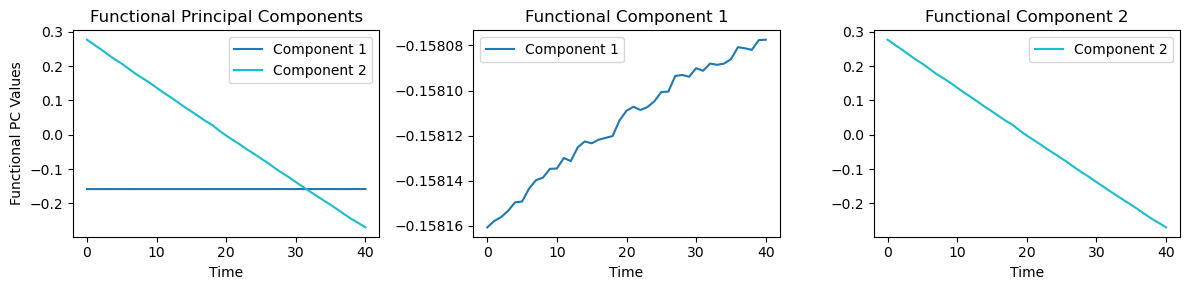

Explain variance FPC1 (%):  99.99893412558436
Explain variance FPC2 (%):  0.0010643207034913115
FPC Scores:
          PC1_Scores  PC2_Scores
3551305 -226.790421   -1.156131
3551322 -225.651822   -0.728055
3551024 -224.514792   -1.120703
3551040 -258.477342   -1.059721
3551361 -168.248660   -0.928142
...             ...         ...
3518396 -157.985813    0.175311
3518410 -481.811357    0.313626
3518425 -548.768348    0.801045
3518428  -34.966198    1.014063
3518429   63.234430    0.242013

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 176 with TestID 3568007
The time series contributing most to PC2 is at index 93 with TestID 3568380


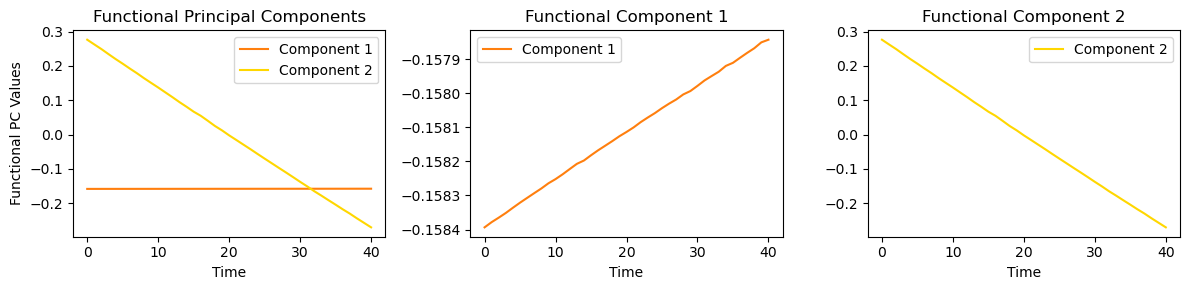

FPCA(_weights=array([0.33333333, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.66666667, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.66666667, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.66666667, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.33333333]),
     n_components=2)

In [34]:
perform_functional_pca(A1_blood_cal_window, color_fpc1='tab:blue', color_fpc2='tab:cyan')
perform_functional_pca(A2_blood_cal_window, color_fpc1='tab:orange', color_fpc2='gold')

## Center data - Cal Window: System 1/2 - Blood

Explain variance FPC1 (%):  99.64435222232132
Explain variance FPC2 (%):  0.027175567140171372
FPC Scores:
           PC1_Scores  PC2_Scores
12414202    0.868115    0.009654
12414210    1.049232   -0.001916
12414251    0.958740    0.003437
12414261    0.838206    0.016210
12416098    0.669864    0.025314
...              ...         ...
12624887   -1.332400    0.007122
12624889   -1.530162   -0.005134
12624890   -0.382219   -0.002491
12479777   -0.305658   -0.023610
12537664   -1.194833   -0.009862

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 9 with TestID 12464486
The time series contributing most to PC2 is at index 110 with TestID 12537672


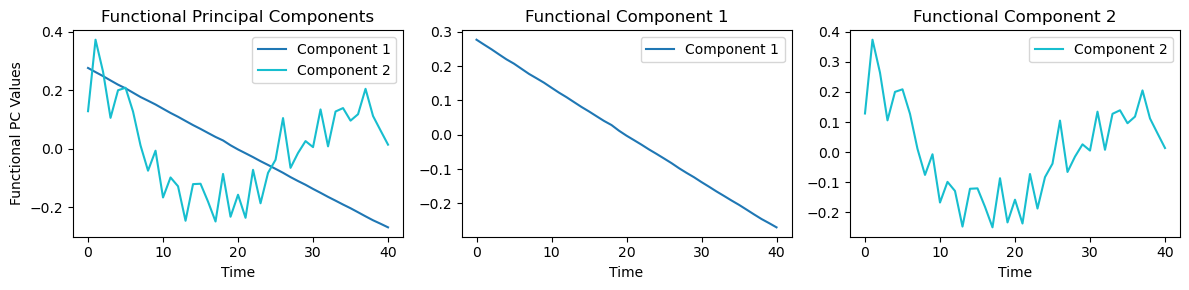

Explain variance FPC1 (%):  99.8657398260884
Explain variance FPC2 (%):  0.034562869019801254
FPC Scores:
          PC1_Scores  PC2_Scores
3551305   -0.927662   -0.009017
3551322   -0.500728    0.006262
3551024   -0.894538   -0.003629
3551040   -0.799338   -0.001076
3551361   -0.758648   -0.001742
...             ...         ...
3518396    0.334467   -0.010627
3518410    0.799002   -0.015055
3518425    1.353876   -0.022145
3518428    1.049286   -0.012266
3518429    0.178312   -0.008806

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 93 with TestID 3568380
The time series contributing most to PC2 is at index 83 with TestID 3562125


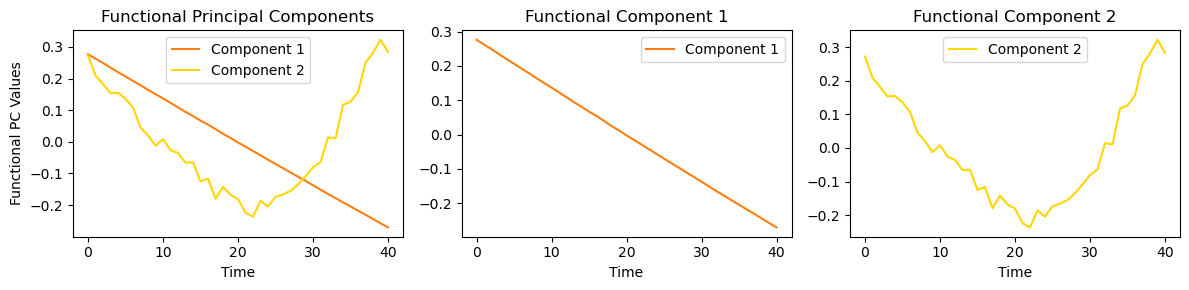

FPCA(_weights=array([0.33333333, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.66666667, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.66666667, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.66666667, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.33333333]),
     n_components=2)

In [35]:
# Nayeli's function for centering
perform_functional_pca(center_data(A1_blood_cal_window), color_fpc1='tab:blue', color_fpc2='tab:cyan')
perform_functional_pca(center_data(A2_blood_cal_window), color_fpc1='tab:orange', color_fpc2='gold')

Explain variance FPC1 (%):  99.99904252431632
Explain variance FPC2 (%):  0.0009541052218730681
FPC Scores:
           PC1_Scores  PC2_Scores
12414202 -499.793787    0.791788
12414210 -556.414625    0.964254
12414251 -520.084647    0.879309
12414261 -516.926217    0.759253
12416098 -478.038719    0.596846
...              ...         ...
12624887  -66.202726   -1.342516
12624889  -87.697253   -1.543550
12624890  -31.326830   -0.387007
12479777  482.438629   -0.231973
12537664 -259.789146   -1.234510

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 188 with TestID 12572826
The time series contributing most to PC2 is at index 9 with TestID 12464486


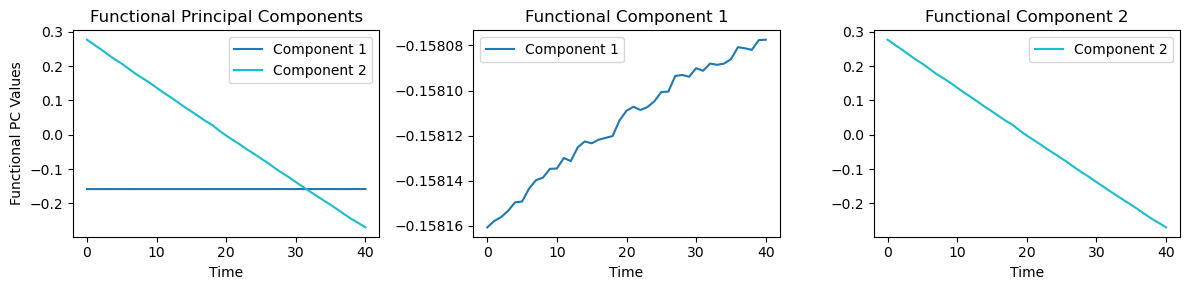

Explain variance FPC1 (%):  99.99893412558436
Explain variance FPC2 (%):  0.0010643207034913133
FPC Scores:
          PC1_Scores  PC2_Scores
3551305 -226.790421   -1.156131
3551322 -225.651822   -0.728055
3551024 -224.514792   -1.120703
3551040 -258.477342   -1.059721
3551361 -168.248660   -0.928142
...             ...         ...
3518396 -157.985813    0.175311
3518410 -481.811357    0.313626
3518425 -548.768348    0.801045
3518428  -34.966198    1.014063
3518429   63.234430    0.242013

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 176 with TestID 3568007
The time series contributing most to PC2 is at index 93 with TestID 3568380


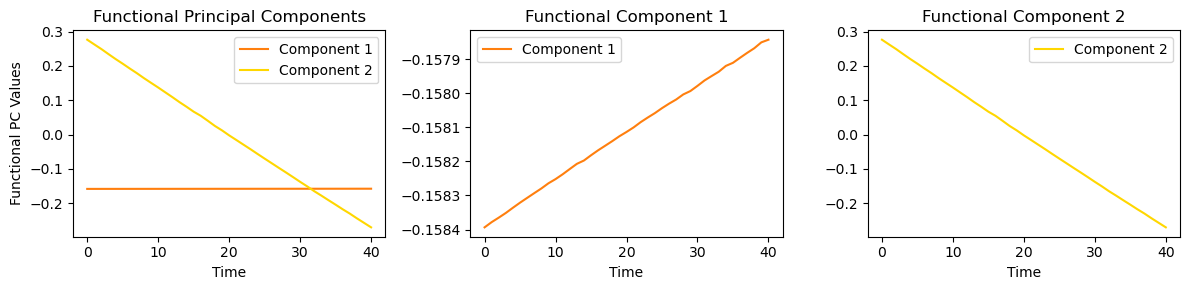

In [34]:
# Jessie's function for centering
perform_functional_pca(center_data_J(A1_blood_cal_window), color_fpc1='tab:blue', color_fpc2='tab:cyan')
perform_functional_pca(center_data_J(A2_blood_cal_window), color_fpc1='tab:orange', color_fpc2='gold')

## Standardize Data Over Timestamps- Cal Window: System 1/2 - Blood

Explain variance FPC1 (%):  99.99904256095331
Explain variance FPC2 (%):  0.0009540685898880335
FPC Scores:
           PC1_Scores  PC2_Scores
12414202   -9.277272    0.014697
12414210  -10.328278    0.017898
12414251   -9.653914    0.016322
12414261   -9.595287    0.014093
12416098   -8.873451    0.011079
...              ...         ...
12624887   -1.228876   -0.024920
12624889   -1.627863   -0.028651
12624890   -0.581497   -0.007184
12479777    8.955125   -0.004306
12537664   -4.822267   -0.022915

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 188 with TestID 12572826
The time series contributing most to PC2 is at index 9 with TestID 12464486


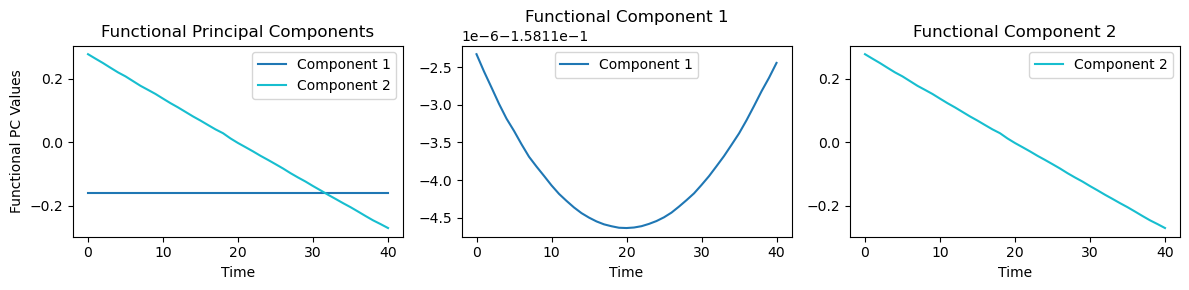

Explain variance FPC1 (%):  99.99893417600565
Explain variance FPC2 (%):  0.0010642697549860254
FPC Scores:
          PC1_Scores  PC2_Scores
3551305   -3.929332   -0.020030
3551322   -3.909590   -0.012614
3551024   -3.889904   -0.019416
3551040   -4.478325   -0.018360
3551361   -2.915050   -0.016080
...             ...         ...
3518396   -2.737201    0.003038
3518410   -8.347684    0.005434
3518425   -9.507740    0.013879
3518428   -0.605777    0.017569
3518429    1.095586    0.004193

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 176 with TestID 3568007
The time series contributing most to PC2 is at index 93 with TestID 3568380


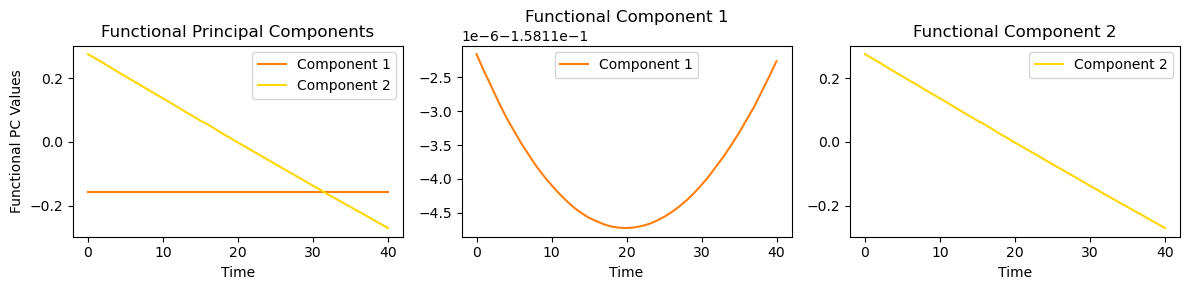

FPCA(_weights=array([0.33333333, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.66666667, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.66666667, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.66666667, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.33333333]),
     n_components=2)

In [36]:
perform_functional_pca(A1_blood_cal_window_scaled_df, color_fpc1='tab:blue', color_fpc2='tab:cyan')
perform_functional_pca(A2_blood_cal_window_scaled_df, color_fpc1='tab:orange', color_fpc2='gold')

## Standardize Data Over TestID's- Cal Window: System 1/2 - Blood

Explain variance FPC1 (%):  92.77569808512875
Explain variance FPC2 (%):  0.8736022911822565
FPC Scores:
           PC1_Scores  PC2_Scores
12414202   -0.758028   -0.807257
12414210    8.328142   -0.842161
12414251    6.190413   -1.023110
12414261   -2.557883   -0.403144
12416098   -3.156508    0.148223
...              ...         ...
12624887   -3.303462   -0.024679
12624889   -3.318128   -0.033087
12624890   -3.303548    0.026943
12479777   -3.304287   -0.129250
12537664   -3.285808   -0.037909

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 40 with TestID 12616876
The time series contributing most to PC2 is at index 21 with TestID 12544054


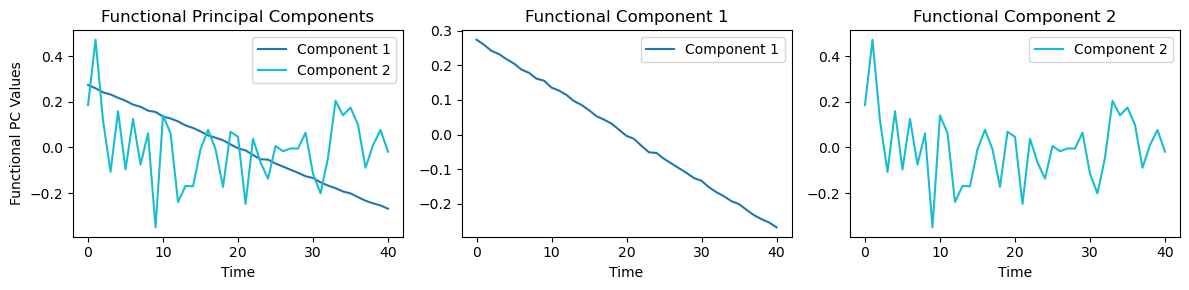

Explain variance FPC1 (%):  96.781244497821
Explain variance FPC2 (%):  0.6860968825091782
FPC Scores:
          PC1_Scores  PC2_Scores
3551305   -3.584036   -0.085037
3551322   -3.570641   -0.056645
3551024   -3.580180   -0.070579
3551040   -3.591012   -0.061299
3551361   -3.585489   -0.057162
...             ...         ...
3518396   -3.593028   -0.146706
3518410   -2.846101   -0.095503
3518425    8.730684   -0.202000
3518428    8.644943   -0.131690
3518429   -3.602407   -0.113239

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 80 with TestID 3561951
The time series contributing most to PC2 is at index 53 with TestID 3550792


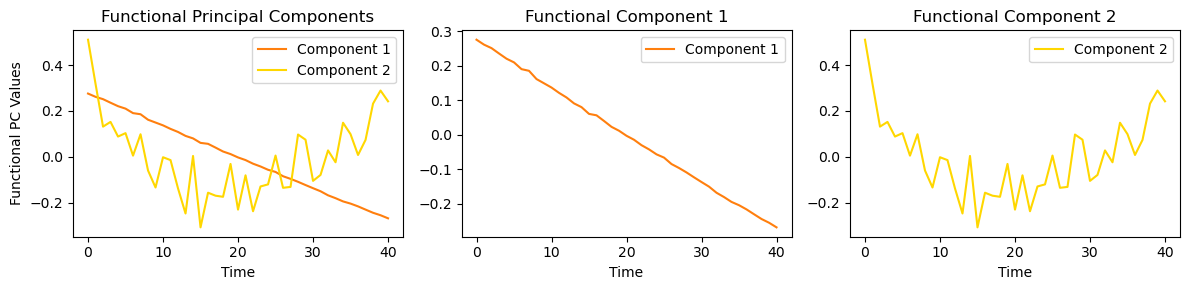

FPCA(_weights=array([0.33333333, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.66666667, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.66666667, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.66666667, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.33333333]),
     n_components=2)

In [37]:
perform_functional_pca(A1_blood_cal_window_TS_scaled_df, color_fpc1='tab:blue', color_fpc2='tab:cyan')
perform_functional_pca(A2_blood_cal_window_TS_scaled_df, color_fpc1='tab:orange', color_fpc2='gold')

## Start 0 - Cal Window: System 1/2 - Blood

Explain variance FPC1 (%):  99.87781445766493
Explain variance FPC2 (%):  0.03222334567598707
FPC Scores:
           PC1_Scores  PC2_Scores
12414202    1.722712    0.019712
12414210    1.935399   -0.062072
12414251    1.798336   -0.041636
12414261    1.636781    0.011874
12416098    1.297662    0.006381
...              ...         ...
12624887   -2.601975   -0.009046
12624889   -2.939711    0.010885
12624890   -0.741544    0.001999
12479777   -0.650855   -0.037116
12537664   -2.277227    0.027194

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 9 with TestID 12464486
The time series contributing most to PC2 is at index 16 with TestID 12509046


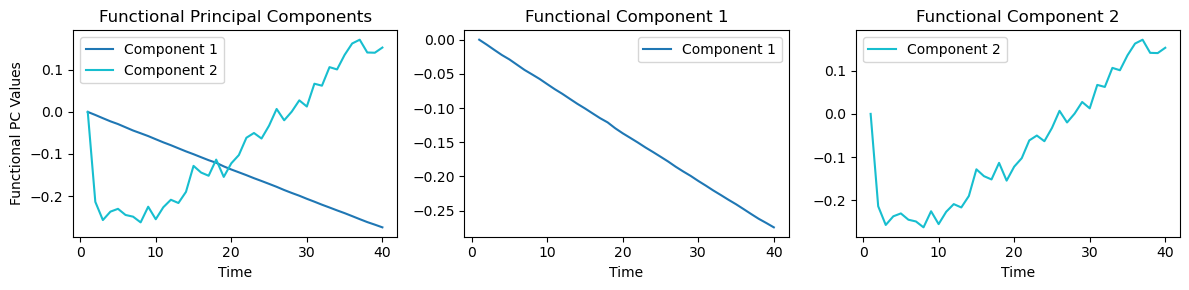

Explain variance FPC1 (%):  99.95534234043755
Explain variance FPC2 (%):  0.01580636239539023
FPC Scores:
          PC1_Scores  PC2_Scores
3551305   -1.833261   -0.017747
3551322   -0.963798    0.005977
3551024   -1.747067   -0.009219
3551040   -1.574702   -0.012124
3551361   -1.464456    0.001752
...             ...         ...
3518396    0.605928   -0.026466
3518410    1.526105   -0.020027
3518425    2.580014   -0.036365
3518428    2.055812   -0.000630
3518429    0.344697   -0.007558

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 93 with TestID 3568380
The time series contributing most to PC2 is at index 83 with TestID 3562125


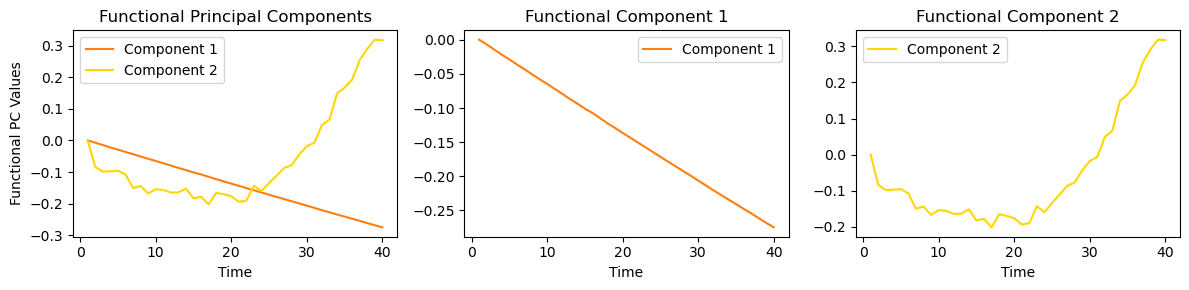

FPCA(_weights=array([0.41666667, 1.08333333, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.08333333, 0.41666667]),
     n_components=2)

In [38]:
perform_functional_pca(A1_blood_cal_window_zero, color_fpc1='tab:blue', color_fpc2='tab:cyan')
perform_functional_pca(A2_blood_cal_window_zero, color_fpc1='tab:orange', color_fpc2='gold')

Explain variance FPC1 (%):  52.567651556066664
Explain variance FPC2 (%):  3.387193915530995
FPC Scores:
           PC1_Scores  PC2_Scores
12414202    0.070364   -0.014732
12414210    0.090427   -0.007596
12414251    0.085714   -0.010374
12414261    0.086760   -0.008297
12416098    0.058392   -0.002556
...              ...         ...
12624887   -0.114854    0.019983
12624889   -0.140530    0.022259
12624890   -0.034401    0.018095
12479777   -0.018485    0.013360
12537664   -0.100749   -0.036419

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 18 with TestID 12527702
The time series contributing most to PC2 is at index 17 with TestID 12526844


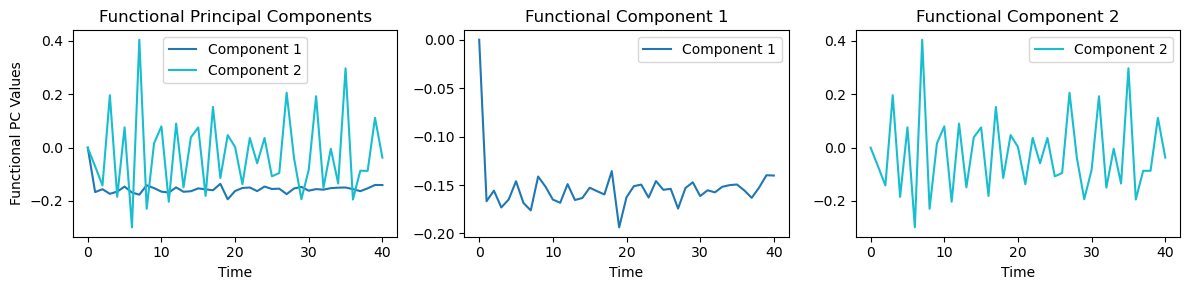

Explain variance FPC1 (%):  80.83526906171168
Explain variance FPC2 (%):  1.3972777763924793
FPC Scores:
          PC1_Scores  PC2_Scores
3551305   -0.076391    0.021806
3551322   -0.043387   -0.016438
3551024   -0.078976   -0.008511
3551040   -0.066856   -0.000311
3551361   -0.068191    0.008453
...             ...         ...
3518396    0.034819    0.015539
3518410    0.073803    0.003161
3518425    0.119177    0.010021
3518428    0.094736   -0.010217
3518429    0.009937   -0.026515

[208 rows x 2 columns]
The time series contributing most to PC1 is at index 93 with TestID 3568380
The time series contributing most to PC2 is at index 68 with TestID 3555407


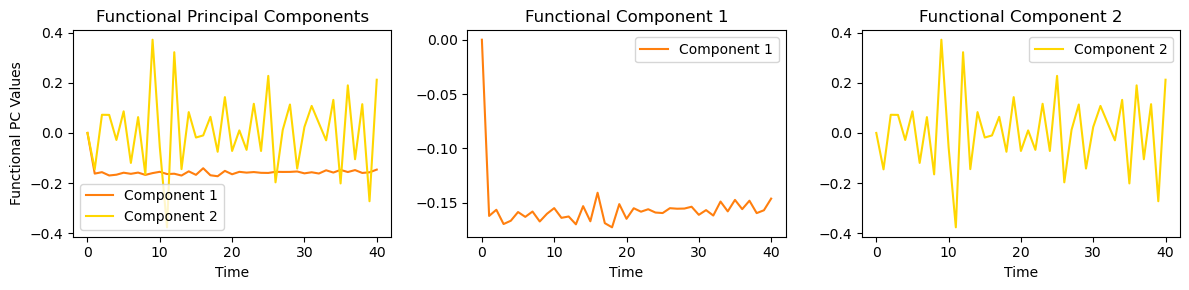

FPCA(_weights=array([0.33333333, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.66666667, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.66666667, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.66666667, 1.33333333, 0.66666667, 1.33333333, 0.66666667,
       1.33333333, 0.66666667, 1.33333333, 0.66666667, 1.33333333,
       0.33333333]),
     n_components=2)

In [39]:
# Differencing 
perform_functional_pca(A1_blood_cal_window_diff, color_fpc1='tab:blue', color_fpc2='tab:cyan')
perform_functional_pca(A2_blood_cal_window_diff, color_fpc1='tab:orange', color_fpc2='gold')

# 8 FPCA

## 8.1. Functional PCA characterization function

In [40]:
def fpca_two_inputs(time_series_s1, time_series_s2, y_axis_min=None, y_axis_max=None):
    """
    Performs Functional Principal Component Analysis (FPCA) on two sets of time series data from different systems
    and plots the first principal component for both systems on the same graph.

    Parameters:
    time_series_s1 (pd.DataFrame): A pandas DataFrame representing time series data from System 1. Each row represents
                                   a time series and each column represents a time point.
    time_series_s2 (pd.DataFrame): A pandas DataFrame representing time series data from System 2. Each row represents
                                   a time series and each column represents a time point.
    y_axis_min (float, optional): The minimum value for the y-axis in the plot. Defaults to None.
    y_axis_max (float, optional): The maximum value for the y-axis in the plot. Defaults to None.

    Returns:
    tuple: A tuple containing two pandas DataFrames representing the functional principal component scores for System 1
           and System 2 respectively.

    Prints:
    - The explained variance ratio of the first principal component for both systems.
    - The functional principal component scores for each time series in both systems.
    - Plots the first principal component for both systems on the same graph.

    """
    # Convert the data matrix to an FDataGrid object
    fd_s1 = FDataGrid(data_matrix=time_series_s1, grid_points=time_series_s1.columns.astype(float)) # System 1
    fd_s2 = FDataGrid(data_matrix=time_series_s2, grid_points=time_series_s2.columns.astype(float)) # System 2

    # Apply Functional PCA for System 1
    fpca_s1 = FPCA(n_components=2, centering=True)
    fpca_s1.fit(fd_s1)
    fpc_and_scores_s1 = fpca_s1.transform(fd_s1)

    # Apply Functional PCA for System 2
    fpca_s2 = FPCA(n_components=2)
    fpca_s2.fit(fd_s2)
    fpc_and_scores_s2 = fpca_s2.transform(fd_s2)

    # --- Explain variance ratio ---
    # System 1
    print('S1 Explain variance PC1 (%): ', fpca_s1.explained_variance_ratio_[0] * 100)
    #print('S1 Explain variance PC2 (%): ', fpca_s1.explained_variance_ratio_[1] * 100)
    # System 2
    print('S2 Explain variance PC1 (%): ', fpca_s2.explained_variance_ratio_[0] * 100)
    #print('S2 Explain variance PC2 (%): ', fpca_s2.explained_variance_ratio_[1] * 100)

    # --- Loadings ---
    # Extract the principal components (loadings)
    principal_components_s1 = fpca_s1.components_ # System 1
    principal_components_s2 = fpca_s2.components_ # System 2

    # --- Scores ---
    # Print the scores to see contributions of each time series to each principal component

    # System 1
    pc_scores_s1 = pd.DataFrame(fpc_and_scores_s1, columns=['PC1_Scores', 'PC2_Scores'],
                                index=[time_series_s1.index[i] for i in range(time_series_s1.shape[0])])
    # System 2
    pc_scores_s2 = pd.DataFrame(fpc_and_scores_s2, columns=['PC1_Scores', 'PC2_Scores'],
                                index=[time_series_s2.index[i] for i in range(time_series_s2.shape[0])])

    # --- Plotting First Principal Component for both Systems ---
    # Extracting data for System 1
    x1 = fpca_s1.components_[0].grid_points[0]
    y1 = fpca_s1.components_[0].data_matrix[0].flatten()

    # Extracting data for System 2
    x2 = fpca_s2.components_[0].grid_points[0]
    y2 = fpca_s2.components_[0].data_matrix[0].flatten()

    # Plotting both curves in the same graph
    fig = plt.figure(figsize=(5, 3))
    plt.plot(x1, y1, linestyle='-', label='Component 1 - S1')
    plt.plot(x2, y2, linestyle='-', label='Component 1 - S2')

    plt.legend()
    plt.grid(False)
    plt.xlabel('Time')
    plt.ylabel('Functional PC 1 Values')
    plt.title('System 1 versus System 2')
    plt.ylim(y_axis_min, y_axis_max)
    plt.show()

    return pc_scores_s1, pc_scores_s2,fpca_s1.components_[0],fpca_s2.components_[0]

In [41]:
def create_pc_scores_plots(pc_scores_s1, pc_scores_s2, features_s1, features_s2):
    """
    Creates scatterplots for the functional principal component scores mapping with colors the additional features for every TestID for two systems.

    Parameters:
    pc_scores_s1 (pd.DataFrame): A pandas DataFrame representing the functional principal component scores for System 1.
    pc_scores_s2 (pd.DataFrame): A pandas DataFrame representing the functional principal component scores for System 2.
    features_s1 (pd.DataFrame): A pandas DataFrame representing additional features for System 1.
    features_s2 (pd.DataFrame): A pandas DataFrame representing additional features for System 2.

    Returns:
    scatterplots: A concatenated chart containing scatterplots of the functional principal component scores combined with additional features for both systems.
    """
    # --- Scores combined with Additional Features ---
    # Reset the index, making the index a column in the DataFrame
    pc_scores_s1_reset = pc_scores_s1.reset_index()
    pc_scores_s2_reset = pc_scores_s2.reset_index()
    pc_scores_s1_reset.rename(columns={'index': 'TestID'}, inplace=True)
    pc_scores_s2_reset.rename(columns={'index': 'TestID'}, inplace=True)

    # Merging functional pc scores and additional features by TestID
    system1_scores_merged = pd.merge(pc_scores_s1_reset, features_s1, how='inner', on=['TestID'])
    system2_scores_merged = pd.merge(pc_scores_s2_reset, features_s2, how='inner', on=['TestID'])

    # --- Characterization of the Functional PC Scores ---

    # Select Features
    selected_columns = ['TestID', 'PC1_Scores','PC2_Scores','FluidType','AgeOfCardInDaysAtTimeOfTest', 'AmbientTemperature', 'Fluid_Temperature_Filled']
    data_s1 = system1_scores_merged[selected_columns].copy()
    data_s2 = system2_scores_merged[selected_columns].copy()

    # Binning continuous predictors into discrete intervals
    data_s1.loc[:, 'AmbientTempBin'] = pd.cut(data_s1['AmbientTemperature'],  bins=[-1, 20, 26, 100], labels=['Below 20', '20-26', 'Above 26'])
    data_s2.loc[:, 'AmbientTempBin'] = pd.cut(data_s2['AmbientTemperature'],  bins=[-1, 20, 26, 100], labels=['Below 20', '20-26', 'Above 26'])
    data_s1.loc[:, 'FluidTempBin'] = pd.cut(data_s1['Fluid_Temperature_Filled'],  bins=[-1, 20, 26, 100], labels=['Below 20', '20-26', 'Above 26'])
    data_s2.loc[:, 'FluidTempBin'] = pd.cut(data_s2['Fluid_Temperature_Filled'],  bins=[-1, 20, 26, 100], labels=['Below 20', '20-26', 'Above 26'])

    # CardAge by bins of 28 days
    # Determine the max age to set the range for bins
    max_age = data_s2['AgeOfCardInDaysAtTimeOfTest'].max()+1

    # Define the custom bins without duplicates
    bins_age = [0, 10, 28] + list(np.arange(56, max_age + 28, 28))

    # Create labels for the bins
    labels_age = ['[0-9]', '(9-28]'] + [f'({i}-{i+28}]' for i in np.arange(28, max_age, 28)]

    # Assign bins to the AgeBin column
    data_s1.loc[:, 'AgeBin'] = pd.cut(data_s1['AgeOfCardInDaysAtTimeOfTest'], bins=bins_age, labels=labels_age)
    data_s2.loc[:, 'AgeBin'] = pd.cut(data_s2['AgeOfCardInDaysAtTimeOfTest'], bins=bins_age, labels=labels_age)

    # --- Define a color map for fluid types ---
    color_map_temp = {
        'Below 20': '#4e79a7',
        '20-26': '#f28e2b',
        'Above 26': '#e16759',
    }

    # Combine data to get the overall min and max for both axes
    combined_data = pd.concat([data_s1, data_s2])

    # Determine the range for x and y axes
    min_x = combined_data['PC1_Scores'].min()
    max_x = combined_data['PC1_Scores'].max()
    min_y = combined_data['PC2_Scores'].min()
    max_y = combined_data['PC2_Scores'].max()

    # --- Visualizations ---
    # System 1
    scatter_age_s1 = alt.Chart(data_s1).mark_circle().encode(
    alt.X('PC1_Scores', title="FPC Score 1", scale=alt.Scale(domain=[min_x, max_x])),
    alt.Y('PC2_Scores', title="FPC Score 2", scale=alt.Scale(domain=[min_y, max_y])),
    color=alt.Color('AgeBin', scale=alt.Scale(scheme='tableau10'), title="Days"),
    tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('AgeOfCardInDaysAtTimeOfTest', title="Card Age")]
    ).properties(
        title='Card Age',
        width=280,
        height=280
   )


    scatter_temp_s1 = alt.Chart(data_s1).mark_circle().encode(
        alt.X('PC1_Scores', title="FPC Score 1", scale=alt.Scale(domain=[min_x, max_x])),
        alt.Y('PC2_Scores', title="FPC Score 2", scale=alt.Scale(domain=[min_y, max_y])),
        color=alt.Color('AmbientTempBin', scale=alt.Scale(domain=list(color_map_temp.keys()), range=list(color_map_temp.values())), title="°C"),
        tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('AmbientTemperature', title="Ambient Temperature")]
    ).properties(
        title='Ambient Temperature',
        width=280,
        height=280
    )


    scatter_fluid_s1 = alt.Chart(data_s1).mark_circle().encode(
        alt.X('PC1_Scores', title="FPC Score 1", scale=alt.Scale(domain=[min_x, max_x])),
        alt.Y('PC2_Scores', title="FPC Score 2", scale=alt.Scale(domain=[min_y, max_y])),
        color=alt.Color('FluidType', scale=alt.Scale(scheme='tableau10'), title="Fluid"),
        tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('FluidType', title="Fluid Type")]
    ).properties(
        title='Fluid Type',
        width=280,
        height=280
    )

    scatter_fluidTemp_s1 = alt.Chart(data_s1).mark_circle().encode(
        alt.X('PC1_Scores', title="FPC Score 1", scale=alt.Scale(domain=[min_x, max_x])),
        alt.Y('PC2_Scores', title="FPC Score 2", scale=alt.Scale(domain=[min_y, max_y])),
        color=alt.Color('FluidTempBin', scale=alt.Scale(domain=list(color_map_temp.keys()), range=list(color_map_temp.values())), title="°C"),
        tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('Fluid_Temperature_Filled', title="Fluid Temperature")]
    ).properties(
        title='Fluid Temperature',
        width=280,
        height=280
    )

    # System 2
    scatter_age_s2 = alt.Chart(data_s2).mark_circle().encode(
        alt.X('PC1_Scores', title="FPC Score 1", scale=alt.Scale(domain=[min_x, max_x])),
        alt.Y('PC2_Scores', title="FPC Score 2", scale=alt.Scale(domain=[min_y, max_y])),
        color=alt.Color('AgeBin', scale=alt.Scale(scheme='tableau10'), title="Days"),
        tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('AgeOfCardInDaysAtTimeOfTest', title="Card Age")]
    ).properties(
        title='Card Age',
        width=280,
        height=280
    )

    scatter_temp_s2 = alt.Chart(data_s2).mark_circle().encode(
        alt.X('PC1_Scores', title="FPC Score 1", scale=alt.Scale(domain=[min_x, max_x])),
        alt.Y('PC2_Scores', title="FPC Score 2", scale=alt.Scale(domain=[min_y, max_y])),
        color=alt.Color('AmbientTempBin', scale=alt.Scale(domain=list(color_map_temp.keys()), range=list(color_map_temp.values())), title="°C"),
        tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('AmbientTemperature', title="Ambient Temperature")]
    ).properties(
        title='Ambient Temperature',
        width=280,
        height=280
    )

    scatter_fluid_s2 = alt.Chart(data_s2).mark_circle().encode(
        alt.X('PC1_Scores', title="FPC Score 1", scale=alt.Scale(domain=[min_x, max_x])),
        alt.Y('PC2_Scores', title="FPC Score 2", scale=alt.Scale(domain=[min_y, max_y])),
        color=alt.Color('FluidType', scale=alt.Scale(scheme='tableau10'), title="Fluid"),
        tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('FluidType', title="Fluid Type")]
    ).properties(
        title='Fluid Type',
        width=280,
        height=280
    )

    scatter_fluidTemp_s2 = alt.Chart(data_s2).mark_circle().encode(
        alt.X('PC1_Scores', title="FPC Score 1", scale=alt.Scale(domain=[min_x, max_x])),
        alt.Y('PC2_Scores', title="FPC Score 2", scale=alt.Scale(domain=[min_y, max_y])),
        color=alt.Color('FluidTempBin', scale=alt.Scale(domain=list(color_map_temp.keys()), range=list(color_map_temp.values())), title="°C"),
        tooltip=['TestID', 'PC1_Scores', 'PC2_Scores', alt.Tooltip('Fluid_Temperature_Filled', title="Fluid Temperature")]
    ).properties(
        title='Fluid Temperature',
        width=280,
        height=280
    )


    # --- Display the plots ---
    # System 1 plots
    s1_plots = alt.hconcat(
        scatter_fluid_s1, scatter_age_s1, scatter_temp_s1, scatter_fluidTemp_s1
    ).resolve_scale(
        color='independent'
    ).properties(
        title='System 1'
    )

    # System 2 plots
    s2_plots = alt.hconcat(
        scatter_fluid_s2, scatter_age_s2, scatter_temp_s2, scatter_fluidTemp_s2
    ).resolve_scale(
        color='independent'
    ).properties(
        title='System 2'
    )

    # Concatenating plots in same grid
    plots_vconcatenated = alt.vconcat(
        s1_plots,
        s2_plots
    ).configure_view(
        stroke=None
    )

    return plots_vconcatenated

## 8.2 Functional PC1 plots (both systems) and Characterization of FPC Scores

### Raw Data: System 1 versus System 2: Sensor A - Blood - Cal Window

S1 Explain variance PC1 (%):  99.99904252431632
S2 Explain variance PC1 (%):  99.99893412558436


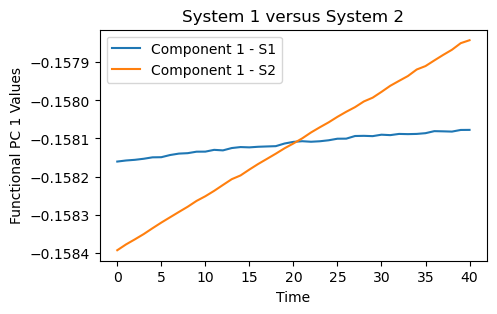

alt.VConcatChart(...)

In [42]:
pc_scores_s1_A_blood_cal_window, pc_scores_s2_A_blood_cal_window, fpca_s1_A_blood_cal_window,fpca_s2_A_blood_cal_window = fpca_two_inputs(A1_blood_cal_window, A2_blood_cal_window)
create_pc_scores_plots(pc_scores_s1_A_blood_cal_window, pc_scores_s2_A_blood_cal_window, A1_Merged, A2_Merged)

### Centered Data: System 1 versus System 2: Sensor A - Blood - Cal Window

S1 Explain variance PC1 (%):  99.64435222232132
S2 Explain variance PC1 (%):  99.8657398260884


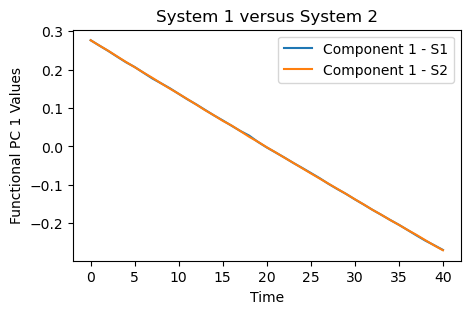

alt.VConcatChart(...)

In [43]:
# Nayeli's function for centering the data
centered_pc_scores_s1_A_blood_cal_window, centered_pc_scores_s2_A_blood_cal_window, centered_fpca_s1_A_blood_cal_window, centered_fpca_s2_A_blood_cal_window = fpca_two_inputs(center_data(A1_blood_cal_window), center_data(A2_blood_cal_window))
create_pc_scores_plots(centered_pc_scores_s1_A_blood_cal_window, centered_pc_scores_s2_A_blood_cal_window, A1_Merged, A2_Merged)

S1 Explain variance PC1 (%):  99.99904252431632
S2 Explain variance PC1 (%):  99.99893412558436


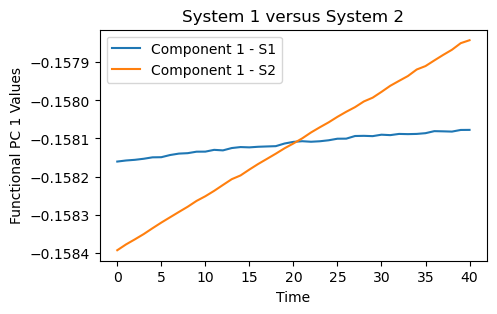

alt.VConcatChart(...)

In [44]:
# Jessie's function for centering data
centered2_pc_scores_s1_A_blood_cal_window, centered2_pc_scores_s2_A_blood_cal_window, centered2_fpca_s1_A_blood_cal_window, centered2_fpca_s2_A_blood_cal_window = fpca_two_inputs(center_data_J(A1_blood_cal_window), center_data_J(A2_blood_cal_window))
create_pc_scores_plots(centered2_pc_scores_s1_A_blood_cal_window, centered2_pc_scores_s2_A_blood_cal_window, A1_Merged, A2_Merged)

### Standardize Data: System 1 versus System 2: Sensor A - Blood - Cal Window

S1 Explain variance PC1 (%):  99.99904256095331
S2 Explain variance PC1 (%):  99.99893417600565


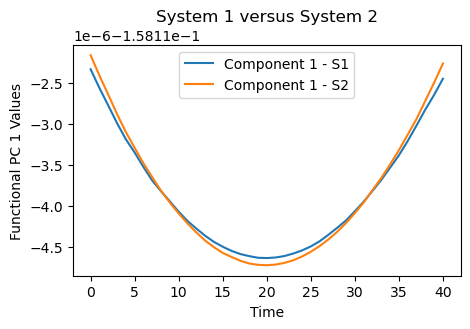

alt.VConcatChart(...)

In [45]:
standardized_pc_scores_s1_A_blood_cal_window, standardized_pc_scores_s2_A_blood_cal_window, standardized_fpca_s1_A_blood_cal_window, standardized_fpca_s2_A_blood_cal_window = fpca_two_inputs(A1_blood_cal_window_scaled_df, A2_blood_cal_window_scaled_df)
create_pc_scores_plots(standardized_pc_scores_s1_A_blood_cal_window, standardized_pc_scores_s2_A_blood_cal_window, A1_Merged, A2_Merged)

### Standardize Data TestId's: System 1 versus System 2: Sensor A - Blood - Cal Window

S1 Explain variance PC1 (%):  92.77569808512875
S2 Explain variance PC1 (%):  96.781244497821


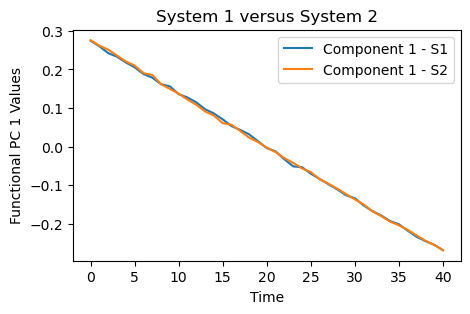

alt.VConcatChart(...)

In [46]:
standardized2_pc_scores_s1_A_blood_cal_window, standardized2_pc_scores_s2_A_blood_cal_window, standardized2_fpca_s1_A_blood_cal_window, standardized2_fpca_s2_A_blood_cal_window = fpca_two_inputs(A1_blood_cal_window_TS_scaled_df, A2_blood_cal_window_TS_scaled_df)
create_pc_scores_plots(standardized2_pc_scores_s1_A_blood_cal_window, standardized2_pc_scores_s2_A_blood_cal_window, A1_Merged, A2_Merged)

# Start 0: System 1 versus System 2: Sensor A - Blood - Cal Window

S1 Explain variance PC1 (%):  99.87781445766493
S2 Explain variance PC1 (%):  99.95534234043755


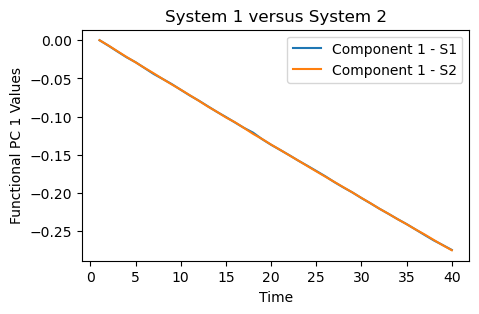

alt.VConcatChart(...)

In [47]:
zero_pc_scores_s1_A_blood_cal_window, zero_pc_scores_s2_A_blood_cal_window, zero_fpca_s1_A_blood_cal_window, zero_fpca_s2_A_blood_cal_window = fpca_two_inputs(A1_blood_cal_window_zero, A2_blood_cal_window_zero)
create_pc_scores_plots(zero_pc_scores_s1_A_blood_cal_window, zero_pc_scores_s2_A_blood_cal_window, A1_Merged, A2_Merged)

S1 Explain variance PC1 (%):  52.567651556066664
S2 Explain variance PC1 (%):  80.83526906171168


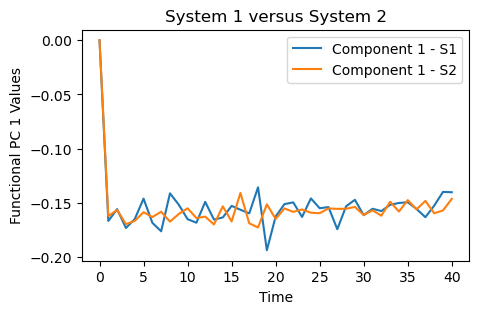

alt.VConcatChart(...)

In [48]:
diff_pc_scores_s1_A_blood_cal_window, diff_pc_scores_s2_A_blood_cal_window, diff_fpca_s1_A_blood_cal_window, diff_fpca_s2_A_blood_cal_window = fpca_two_inputs(A1_blood_cal_window_diff, A2_blood_cal_window_diff)
create_pc_scores_plots(diff_pc_scores_s1_A_blood_cal_window, diff_pc_scores_s2_A_blood_cal_window, A1_Merged, A2_Merged)